# IMPORTS

In [82]:
#@title
#INSTALLATIONS
!mkdir models
!pip install -q keras
import keras
!pip install -q tqdm
import tqdm
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

#LE FUTUR WESH
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

#CLASSIQUES
from google.colab import files, auth
from oauth2client.client import GoogleCredentials
import numpy as np
np.random.seed(1000)
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
from tqdm import tqdm
import matplotlib.pyplot as plt
import timeit
import sklearn.metrics as sklm
import copy
import math
import types as python_types
import warnings
import pickle

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('ATTENTION ! PAS DE GPU !')
else:
  print('Found GPU at: {}'.format(device_name))

#KERAS
import keras
from keras import activations, initializers, regularizers, constraints,metrics
from keras.legacy import interfaces
from keras.engine import InputSpec, Layer
from keras.layers import Input,BatchNormalization
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.optimizers import Adam, Adagrad
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.utils import np_utils
from keras.utils.generic_utils import func_dump, func_load, deserialize_keras_object

# DRIVE AUTHENTIFICATION
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

mkdir: cannot create directory ‘models’: File exists
Found GPU at: /device:GPU:0


# CONSTANTES

In [0]:
#@title
# QUELQUES VARIABLES

adagrad = Adagrad(lr=0.001, epsilon=None, decay=0.0) #c'est celui-là qui est utilisé pour tous les modèles
adam = Adam(lr=0.0002, beta_1=0.5)

randomVectorSize = 100

d_losses = []
g_losses = []
c_losses = []
r_losses = []

# Nombre de learning steps par batch du DISCRIMINATOR
nb_step_discriminator = 1

# Seuil de score du DISCRIMINATOR en deça duquel on considere un exemple fake comme exemple classe 1 du REJECTOR
seuil_rejet_RejectionTraining = 0.40

# Seuil de score du DISCRIMINATOR au-delà duquel on considere un exemple fake comme exemple classe 0 du REJECTOR
seuil_accept_RejectionTraining = 0.55

# Nombre maximum d'exemples dans allGeneratedSamples
max_GeneratedSamples = 20000

# Permutation aléatoire des exemples dans allGeneratedSamples lorsque max_GeneratedSamples exemples est atteint
randomPermut_GeneratedSamples = True

# Tri des exemples dans allGeneratedSamples en fonction de leurs scores
sort_GeneratedSamples = False

# Cible des exemples negatifs 
target_neg = int(0)

# Cible des exemples positifs 
target_pos = int(1)

#Seuil à appliquer pour les prédictions du REJECTOR
seuil_rejector = 0.5

#Seuil à appliquer aux sorties du REJECTOR lors de l'entraînement du CLASSIFIER
seuil_rejector_to_train_classifier = 0.0

# Taux de decroisance de la variance des rbf units
Decrease_rate_alpha = 1.1  

# Utilisation des données perturbées
usePerturbatedData = False

# Nombre de classes dans MNIST
nb_classes = 10

# Choix des classes à traiter par le réseau
classes_train = np.random.choice(range(nb_classes), size=3, replace=False)
classes_train =[0, 4, 7]
classes_not_train = [i for i in range(nb_classes) if i not in classes_train]

In [0]:
#@title
# IMPORTATION MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32).reshape((X_train.shape[0],28,28,1)) - 127.5)/127.5
Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_train = Y_train * 0.9
X_test = (X_test.astype(np.float32).reshape((X_test.shape[0],28,28,1)) - 127.5)/127.5
Y_test = np_utils.to_categorical(y_test, nb_classes)
#Y_test = Y_test * 0.9

indices = np.where(np.isin(y_train, classes_train))
X_train_restricted = X_train[indices,:]
X_train_restricted = X_train_restricted.reshape(X_train_restricted.shape[1],28,28,1)
Y_train_restricted = Y_train[indices,:]
Y_train_restricted = Y_train_restricted.reshape(Y_train_restricted.shape[1],10)

indices = np.where(np.isin(y_train, classes_not_train))
X_train_out = X_train[indices,:]
X_train_out = X_train_out.reshape(X_train_out.shape[1],28,28,1)
Y_train_out = Y_train[indices,:]
Y_train_out = Y_train_out.reshape(Y_train_out.shape[1],10)

indices = np.where(np.isin(y_test, classes_train))
X_test_restricted = X_test[indices,:]
X_test_restricted = X_test_restricted.reshape(X_test_restricted.shape[1],28,28,1)
Y_test_restricted = Y_test[indices,:]
Y_test_restricted = Y_test_restricted.reshape(Y_test_restricted.shape[1],10)

indices = np.where(np.isin(y_test, classes_not_train))
X_test_out = X_test[indices,:]
X_test_out = X_test_out.reshape(X_test_out.shape[1],28,28,1)
Y_test_out = Y_test[indices,:]
Y_test_out = Y_test_out.reshape(Y_test_out.shape[1],10)

# FONCTION UTILITAIRES

In [0]:
#@title CALCUL DE PERFORMANCES
###________FONCTIONS POUR CALCULER LES PERFORMANCES________###

#MOYENNE DES PREDICTIONS CORRECTES
def mean_pred_pos(y_true, y_pred):
  good_examples = np.where(y_true[:,0] ==0)
  return K.mean(y_pred[good_examples])
  
#MOYENNE DES PREDICTIONS FAUSSES
def mean_pred_neg(y_true, y_pred):
  good_examples = np.where(y_true[:,0] ==1)
  return K.mean(y_pred)

#RECALL RATE (vrais positifs / (vrais positifs + faux négatifs))
def recall(y_true, y_pred):
  res  = K.eval(tf.multiply (y_true, y_pred))
  true_positives = np.sum(np.round(np.clip(res, 0, 1)))
  possible_positives = np.sum(np.round(np.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

#PRECISION (vrais positifs / (vrais positifs + faux positifs))
def precision(y_true, y_pred):
  res  = K.eval(tf.multiply (y_true, y_pred))
  true_positives = np.sum(np.round(np.clip(res, 0, 1)))
  predicted_positives = np.sum(np.round(np.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

#F1 = moyenne harmonique du recall rate et de la précision
def f1(y_true, y_pred):
    precision_f1 = precision(y_true, y_pred)
    recall_f1 = recall(y_true, y_pred)
    return 2*((precision_f1*recall_f1)/(precision_f1+recall_f1))

#AREA UNDER CURVE de la courbe Faux positifs/Vrais positifs...
def auc(y_true, y_pred):  
  fpr, tpr, thresholds = sklm.roc_curve(y_true, y_pred, pos_label=1)
  return sklm.auc(fpr, tpr)

In [0]:
#@title COUCHES RBF
###________TROIS CLASSES POUR IMPLEMENTER DES COUCHES RBF________###

class RBFLayer(Layer):
    def __init__(self, alpha=1000.0, alpha_initializer='zeros',
                 alpha_regularizer=None,
                 alpha_constraint=None, 
                 **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.supports_masking = True
        self.supports_masking = True
        self.alpha_initializer = keras.initializers.Constant(value=1000.0)
        self.alpha_regularizer = regularizers.get(alpha_regularizer)
        self.alpha_constraint = constraints.get(alpha_constraint)
        self.alpha = self.add_weight(shape=(1,),
                                     name='alpha',
                                     initializer=self.alpha_initializer,
                                     regularizer=self.alpha_regularizer,
                                     constraint=self.alpha_constraint)
        self.trainable = False

    def call(self, inputs):
        y = - inputs / self.alpha[0]
        y = keras.backend.exp(y)
        return y

    def get_config(self):
        config = {
            'alpha_initializer': initializers.serialize(self.alpha_initializer),
            'alpha_regularizer': regularizers.serialize(self.alpha_regularizer),
            'alpha_constraint': constraints.serialize(self.alpha_constraint),
            'shared_axes': self.shared_axes
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

class RBF(Layer):
    @interfaces.legacy_dense_support
    def __init__(self, units,
                 activation=None,
                 use_bias=False,
                 kernel_initializer='TruncatedNormal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 sigma = 1000.0,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(RBF, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.sigma = sigma
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        norm_x = K.transpose(K.sum(inputs * inputs , axis=1))
        norm_w = K.sum(self.kernel *self.kernel , axis=0)
        norm_x = keras.backend.expand_dims(norm_x, axis=-1)
        prod_scal = -2 * K.dot(inputs, self.kernel)
        print ("Shapes : ", norm_x.shape, norm_w.shape, prod_scal.shape) 
        a = tf.add(norm_x, prod_scal) # -2 *  prod_scal)
        y = tf.add(a, norm_w )
        y = - y / self.sigma
        y = keras.backend.exp(y)
        return y

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(RBF, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class RBF2(Layer):
    @interfaces.legacy_dense_support
    def __init__(self, units,
                 activation=None,
                 use_bias=False,
                 kernel_initializer='TruncatedNormal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(RBF2, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs):
        norm_x = K.transpose(K.sum(inputs * inputs , axis=1))
        norm_w = K.sum(self.kernel *self.kernel , axis=0)
        norm_x = keras.backend.expand_dims(norm_x, axis=-1)
        prod_scal = -2 * K.dot(inputs, self.kernel)
        print ("Shapes : ", norm_x.shape, norm_w.shape, prod_scal.shape) 
        a = tf.add(norm_x, prod_scal) # -2 *  prod_scal)
        y = tf.add(a, norm_w )
        return y

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(RBF2, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
#@title AFFICHAGE
###________FONCTIONS D'AFFICHAGE________###

# AFFICHAGE DES LOSS DU GAN
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(d_losses, label='Discriminitive loss')
    plt.plot(g_losses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_e%d.png' % epoch)
    uploaded = drive.CreateFile({'title': 'loss_e%d.png' % epoch})
    uploaded.SetContentFile('loss_e%d.png' % epoch)
    uploaded.Upload()
    
def plotRejector(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(r_losses, label='Rejector loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('rejector_loss_e%d.png' % epoch)
    uploaded = drive.CreateFile({'title': 'rejector_loss_e%d.png' % epoch})
    uploaded.SetContentFile('rejector_loss_e%d.png' % epoch)
    uploaded.Upload()

# EXEMPLES D'IMAGES GENEREES
# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    generator = uploadModels(epoch)[0]
    noise = np.random.normal(0, 1, size=[examples, randomVectorSize])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    file1 = drive.CreateFile({'title': 'gan_generated_image_epoch_%d.png' % epoch} ) # Create GoogleDriveFile instance with title 'Hello.txt'.
    file1.SetContentFile('gan_generated_image_epoch_%d.png' % epoch)
    file1.Upload()
    plt.close()

# SAUVE UNE MOSAIQUE D'EXEMPLES GENERES PAR UNE EPOCH DU GAN
def saveImagesGAN(epoch):
  generator = uploadModels(epoch)[0]
  noise = np.random.normal(0, 1, size=[10, randomVectorSize])
  generatedImages = generator.predict(noise)
  generatedImages = generatedImages.reshape(10, 28, 28)
  Xg = generatedImages[:8]
  nom_file = "gan_generated_image_epoch_" +str(epoch) + ".png"
  np.save(nom_file, Xg)
  uploaded = drive.CreateFile({'title': nom_file})
  uploaded.SetContentFile(nom_file)
  uploaded.Upload()

# EXEMPLES D'IMAGES GENEREES 2
def plotGeneratedImages2(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    generator = uploadModels(epoch)[0]
    noise = np.random.normal(0, 1, size=[10, randomVectorSize])
    generatedImages = generator.predict(noise)
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, :], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    nom_file = 'gan_generated_image_epoch_%d.png' % epoch
    plt.savefig(nom_file)
    uploaded = drive.CreateFile({'title': nom_file})
    uploaded.SetContentFile(nom_file)
    uploaded.Upload()

# AFFICHE LES IMAGES (mettez-en 100 ou moins svp sinon je sais pas ce que ça va faire)
def plotImages(images, dim=(10, 10), figsize=(10, 10)):
    plt.figure(figsize=figsize)
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_perturbated_images.png')
    files.download('gan_perturbated_images.png')  

In [0]:
#@title MISE EN FORME DE DONNEES
###________FONCTIONS DE MISE EN FORME DES DONNEES________###

#OUVRE DES DONNEES PICKLE
def open_data(path):
    vect=[]
    with open(path, 'rb') as fichier:
        mon_depickler = pickle.Unpickler(fichier)
        vect = mon_depickler.load()
    return(vect)

# MET EN FORME LES LABELS ET LES DONNEES POUR LE TEST DU CLASSIFIEUR SUR LES DONNEES NON REJETEES
def data_evaluation_classifier(X_real, y_real):
  y_dgan = rejector.predict(X_real)
  good_examples = np.where(y_dgan[:,0] < seuil_rejector)
  X_disc = X_real[good_examples]
  y_disc = y_real[good_examples]
  weights = np.ones((y_real.shape[0],1))
  return X_disc, y_disc

# MET EN FORME LES LABELS POUR DES ENTREES X TOUTES VRAIES
def data_evaluation_rejector_true(X):
    return X, np.ones((X.shape[0],1))

# MET EN FORME LES LABELS ET LES DONNEES POUR LES IMAGES GENEREES
def data_evaluation_rejector_fake(X_fake, filtre):
  if filtre:
    y_reject = discriminator.predict(X_fake)
    good_examples = np.where(y_reject[:,0] < seuil_rejet_RejectionTraining)
    X_disc = X_fake[good_examples]
    y_disc = np.zeros((X_disc.shape[0],1))
  else:
    X_disc = X_fake[:]
    y_disc = np.zeros((X_disc.shape[0],1))
  return X_disc, y_disc

# MODIFIE DES IMAGES EN FAISANT DU COPIER/COLLER (à reprendre en modifiant)
def imageBatch_mix(batchsize):
  lesindices =  np.random.randint(0, X_train_restricted.shape[0], size=batchsize)
  imageBatch_to_perturb = X_train_restricted[lesindices,:]
  imageBatch_to_perturb = imageBatch_to_perturb.reshape((imageBatch_to_perturb.shape[0], X_train.shape[1]*X_train.shape[2]))
  data_dim = imageBatch_to_perturb.shape[1]
  X_perturbated = imageBatch_to_perturb
  rate1 = 0.9
  seuil1 = int(rate1* (float(data_dim)))
  seuil1 = np.random.randint(0, high=seuil1)
  X_perturbated[:,:seuil1] = imageBatch_to_perturb[:,:seuil1]
  rate2 = 0.9
  seuil2 = int(rate2* (float(data_dim)))
  seuil2 = np.random.randint(0, high=seuil2)
  seuil2 = min(seuil1+seuil2, data_dim)
  p = np.random.permutation(batchsize)
  X_perturbated[:,seuil1:seuil2] = imageBatch_to_perturb[p,seuil1:seuil2]
  p = np.random.permutation(batchsize)  
  X_perturbated[:,seuil2:] = imageBatch_to_perturb[p,seuil2:]
  X_perturbated = X_perturbated.reshape((imageBatch_to_perturb.shape[0], 28, 28, 1))
  return X_perturbated

# RENVOIE UN BATCH D'ENTRAINEMENT POUR LE REJECTOR
def data_train_rejector(X_real, y_real, X_fake, X_perturbated):
    batchSize = X_real.shape[0]
    y_fake_reject = discriminator.predict(X_fake)
    good_examples = np.where(y_fake_reject[:,0] < seuil_rejet_RejectionTraining )
    bad_examples = np.where(y_fake_reject[:,0] > seuil_accept_RejectionTraining )
    X_fake_good = X_fake[good_examples[0]]
    X_fake_good= X_fake_good[:min(X_fake_good.shape[0],batchSize)]
    y_fake_good = np.zeros((y_fake_reject[good_examples[0]].shape[0],1))
    y_fake_good= y_fake_good[:min(X_fake_good.shape[0],batchSize)]
    y_fake_good[:,] = 0
    X_fake_bad = X_fake[bad_examples[0]]
    X_fake_bad = X_fake_bad[:min(X_fake_bad.shape[0],batchSize)]
    y_fake_bad = np.zeros((y_fake_reject[bad_examples[0]].shape[0],1))
    y_fake_bad = y_fake_bad[:min(X_fake_bad.shape[0],batchSize)]
    y_fake_bad[:,] = 1
    y_real_reject = np.ones((X_real.shape[0],1))
    y_perturbated = np.zeros((X_perturbated.shape[0],1))
    if usePerturbatedData:
      X = np.concatenate([X_real, X_fake_good, X_fake_bad, X_perturbated])
      y_rejection = np.concatenate([y_real_reject, y_fake_good, y_fake_bad, y_perturbated])
    else:
      X = np.concatenate([X_real, X_fake_good, X_fake_bad])   
      y_rejection = np.concatenate([y_real_reject, y_fake_good, y_fake_bad])
    weights = np.ones((y_rejection.shape[0],1))
    return X, y_rejection, weights

# RENVOIE LES ELEMENTS DE X_REAL NON REJETES PAR LE REJECTOR (à modifier pour inclure les données perturbées)
def data_train_classifier(X_real, y_real, X_perturbated):
    y_dgan = rejector.predict(X_real)
    good_examples = np.where(y_dgan[:,0] > seuil_rejector_to_train_classifier)
    X_disc = X_real[good_examples]
    y_disc = y_real[good_examples]
    weights = np.ones((y_disc.shape[0],1))
    """
    y_perturbated = np.zeros((X_perturbated.shape[0],y_disc.shape[1]))
    X = np.concatenate([X_disc, X_perturbated])
    y = np.concatenate([y_disc, y_perturbated])
    weights = np.ones((y.shape[0],1))
    """
    return X_disc, y_disc, weights

#APPLIQUE UNE PERMUTATION DES IMAGES GENEREES (optionnel) PUIS FILTRE LES IMAGES EN FONCTION DE LEUR REPONSE AU DISCRIMINATEUR
def filtrage(allgeneratedImages, nb_generated_max = max_GeneratedSamples):
    if randomPermut_GeneratedSamples:
      p = np.random.permutation(range(allgeneratedImages.shape[0]))
      allgeneratedImages = allgeneratedImages[p]
    y_fake_reject = discriminator.predict(allgeneratedImages)
    good_examples = np.where(y_fake_reject[:,0] < seuil_rejet_RejectionTraining )
    X_temp = allgeneratedImages[good_examples]
    if (X_temp.shape[0]> nb_generated_max):
        return X_temp[:nb_generated_max]
    else:
        if (X_temp.shape[0]==0):
            return allgeneratedImages[:min(allgeneratedImages.shape[0],nb_generated_max)]
        else:
            return X_temp          
          
# SAUVEGARDER LES MODELES
def saveModels(epoch):
  generator.save('generator_e%d' % epoch)
  discriminator.save('discriminator_e%d' % epoch)

def saveRejector():
  rejector.save_weights('rejector')
  uploaded = drive.CreateFile({'title': 'rejector'})
  uploaded.SetContentFile('rejector')
  uploaded.Upload()

def loadRejector(rejector):
  liste = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
  for i in liste:
    if i['title'] == 'rejector':
      genID = i['id']
  gen = drive.CreateFile({'id':genID})
  gen.GetContentFile('rejector')
  rejector.load_weights('rejector')

def loadClassifier():
  liste = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
  for i in liste:
    if i['title'] == '10_classifier':
      genID = i['id']
  gen = drive.CreateFile({'id':genID})
  gen.GetContentFile('10_classifier')
  classifier  = keras.models.load_model('10_classifier')
  return classifier

# TELECHARGER LES MODELES
def downloadModels(epoch):
  uploaded = drive.CreateFile({'title': 'generator_e%d' % epoch})
  uploaded.SetContentFile('generator_e%d' % epoch)
  uploaded.Upload()
  uploaded = drive.CreateFile({'title': 'discriminator_e%d' % epoch})
  uploaded.SetContentFile('discriminator_e%d' % epoch)
  uploaded.Upload()

# UPLOADER LES MODELES
def uploadModels(epoch):
  liste = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
  for i in liste:
    if i['title'] == 'generator_e%d' % epoch:
      genID = i['id']
    if i['title'] == 'discriminator_e%d' % epoch:
      discID = i['id']
  gen = drive.CreateFile({'id':genID})
  gen.GetContentFile('generator_e%d' % epoch)
  generator = keras.models.load_model('generator_e%d' % epoch)
  disc = drive.CreateFile({'id':discID})
  disc.GetContentFile('discriminator_e%d' % epoch)
  discriminator = keras.models.load_model('discriminator_e%d' % epoch)
  return generator, discriminator

#Je sais pas encore ni ce que c'est ni à quoi ça sert, ça ne semble pas utilisé
def toutes_data_evaluation_classifier(X, y):
  y_disc = np.concatenate((np.zeros((y.shape[0],1)), y ), axis=1)
  return X, y_disc

# Ne semble pas utilisé
def imageBatch_neg(batchsize):
  lesindices =  np.random.randint(0, X_train.shape[0], size=batchsize*3)
  imageBatch_to_perturb = X_train[lesindices,:]
  X_perturbated = imageBatch_to_perturb[:batchsize] + imageBatch_to_perturb[batchsize:2*batchsize]- imageBatch_to_perturb[2*batchsize:3*batchsize]
  #X_perturbated = (imageBatch_to_perturb[:batchsize] + imageBatch_to_perturb[batchsize:2*batchsize])/2
  return X_perturbated

In [0]:
#@title SEUILLAGES

#Application d'un seuil en sortie du classifier sur la probabilité la plus grande
def test_model(model,seuil,x_test,y_test):
  print("Seuillage sur la probabilité max :")
  print("Seuil = "+str(seuil))
  predictions=model.predict(x_test)
  indices=[]
  for i in range(len(x_test)):
    #print(max(predictions[i]))
    if max(predictions[i])>seuil:
      indices.append(i)
  new_x_test=[]
  new_y_test=[]
  if len(indices)==0:
    print("Toutes les images sont rejetées...")
    return([len(x_test),1])
  for indice in indices:
    new_x_test.append(x_test[indice])
    new_y_test.append(y_test[indice])
  new_x_test=np.array(new_x_test)
  new_y_test=np.array(new_y_test)
  new_score=model.evaluate(new_x_test,new_y_test,batch_size=16)
  nb_total=len(x_test)
  nb_conservees=len(new_x_test)
  nb_rejetees=nb_total-nb_conservees
  rapport_conservees=nb_conservees/nb_total
  print("Nombre d'images conservées : "+str(nb_conservees)+"/"+str(nb_total)+" = "+str(100*rapport_conservees)+"%")
  print("Nombre d'images rejetées : "+str(nb_rejetees))
  print("Score avec les images conservées : ",new_score)
  return([nb_rejetees,new_score[1]])


#Calcul de l'entropie
def entropie(array):
  H=0
  for j in range(len(array)):
    H+=-1*array[j]*np.log2(array[j])
  return(H)


#Application d'un seuil sur l'entropie de la sortie du classifier
def test_model_entropie(model,seuil,x_test,y_test):
  print("Seuillage sur l'entropie : ")
  print("Seuil = "+str(seuil))
  predictions=model.predict(x_test)
  indices=[]
  for i in range(len(x_test)):
    #print(entropie(predictions[i]))
    if entropie(predictions[i])<seuil:
      indices.append(i)
  new_x_test=[]
  new_y_test=[]
  if len(indices)==0:
    print("Toutes les images sont rejetées...")
    return([len(x_test),1])
  for indice in indices:   
    new_x_test.append(x_test[indice])
    new_y_test.append(y_test[indice])
  new_x_test=np.array(new_x_test) 
  new_y_test=np.array(new_y_test)
  new_score=model.evaluate(new_x_test,new_y_test,batch_size=16)
  nb_total=len(x_test)
  nb_conservees=len(new_x_test)
  nb_rejetees=nb_total-nb_conservees
  rapport_conservees=nb_conservees/nb_total
  print("Nombre d'images conservées : "+str(nb_conservees)+"/"+str(nb_total)+" = "+str(100*rapport_conservees)+"%")
  print("Nombre d'images rejetées : "+str(nb_rejetees))
  print("Score avec les images conservées : ",new_score)
  return([nb_rejetees,new_score[1]])


# MODELES

In [85]:
# Generator

g_input = Input(shape=(randomVectorSize,),name="g_input")
x = Dense(7*7*128, kernel_initializer=initializers.RandomNormal(stddev=0.02))  (g_input)
x = LeakyReLU(0.2)                                                             (x)
x = Reshape((7,7,128))                                                         (x)
x = UpSampling2D(size=(2, 2))                                                  (x)
x = Conv2D(64, kernel_size=(5, 5), padding='same')                             (x)
x = LeakyReLU(0.2)                                                             (x)
x = UpSampling2D(size=(2, 2))                                                  (x)
g_prediction = Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh')(x)

generator = Model(input = g_input, output = g_prediction)
generator.compile(optimizer=adagrad, loss='binary_crossentropy')
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
g_input (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_15 (UpSampling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 14, 14, 64)        0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("g_..., outputs=Tensor("co...)`
  if sys.path[0] == '':


In [86]:
# Discriminator

d_input = Input(shape=(28,28,1),name="d_input")
x = Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)) (d_input)
x = LeakyReLU(0.2)                                                 (x)
x = Dropout(0.3)                                                   (x)
x = Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
x = LeakyReLU(0.2)                                                 (x)
x = Dropout(0.3)                                                   (x)
x = Flatten()                                                      (x)
d_prediction = Dense(1, activation='sigmoid', name='d_output')     (x)

discriminator = Model(input = d_input, output = d_prediction)
discriminator.compile(optimizer=adagrad, loss='binary_crossentropy')
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_input (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 7, 7, 128)         0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("d_..., outputs=Tensor("d_...)`
  if sys.path[0] == '':


In [87]:
# GAN

discriminator.trainable = False
gan_input = Input(shape=(randomVectorSize,))
x = generator (gan_input)
gan_prediction = discriminator (x)

gan = Model(input = gan_input, output = gan_prediction)
gan.compile(optimizer=adagrad, loss='binary_crossentropy')
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_36 (Model)             (None, 28, 28, 1)         839937    
_________________________________________________________________
model_37 (Model)             (None, 1)                 212865    
Total params: 1,052,802
Trainable params: 839,937
Non-trainable params: 212,865
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`
  import sys


In [88]:
# Classifier

c_input = Input(shape=(28,28,1), name='c_input')
x =  Conv2D(64, kernel_size=(3, 3), activation='relu') (c_input)
x = MaxPooling2D(pool_size=(2, 2))                     (x)
x = Conv2D(128, (3, 3), activation='relu')             (x)
x = MaxPooling2D(pool_size=(2, 2))                     (x)
x = Dropout(0.25)                                      (x)
x = Flatten()                                          (x)
x = Dense(128, activation='relu')                      (x)
#x = Dropout(0.5)                                       (x)
c_prediction = Dense(10, activation='softmax', name='c_output') (x)

classifier = Model(input = c_input, output = c_prediction)
classifier.compile(optimizer=adagrad, loss= 'binary_crossentropy', metrics=[metrics.categorical_accuracy])
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
c_input (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 3200)              0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("c_..., outputs=Tensor("c_...)`
  del sys.path[0]


In [89]:
# Rejector

r_input = Input(shape=(28,28,1), name='r_input')
x =  Conv2D(64, kernel_size=(3, 3), activation='relu')(r_input)
x = MaxPooling2D(pool_size=(3, 3))                    (x)
x = Conv2D(128, (3, 3), activation='relu')            (x)
x = MaxPooling2D(pool_size=(3, 3))                    (x)
x = Dropout(0.25)                                     (x)
x = Flatten()                                         (x)
#x = RBF(128, sigma=1000.0)                            (x)
x = Dense(128, activation='relu')                     (x)
x = RBF2(300)                                         (x)
x = RBFLayer(alpha=2000.0)                            (x)
#x = BatchNormalization()                              (x)
#x = Dropout(0.5)                                      (x)
r_prediction = Dense(1, activation='sigmoid', name='r_output', use_bias=False) (x)

rejector = Model(input = r_input, output = r_prediction)
rejector.compile(optimizer=adagrad, loss= 'mse')  #  metrics=['acc', f1, precision, recall])
rejector.summary()

Shapes :  (?, 1) (300,) (?, 300)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
r_input (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 6, 6, 128)         73856     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 512)   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("r_..., outputs=Tensor("r_...)`


# TRAININGS ET BASES DE DONNEES

In [0]:
#@title ENTRAINEMENT DE TOUS LES RESEAUX
def train_all(X_train, Y_train, X_test_in, Y_test_in, X_test_out, Y_test_out, epochs=100, batchSize=128):
  #INITIALISATION...
  batchCount = int(X_train.shape[0] / batchSize)
  print ('Epochs:', epochs)
  print ('Batch size:', batchSize)
  print ('Batches per epoch:', batchCount)
  noise = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
  allgeneratedImages = generator.predict(noise)

  for e in range(1, epochs+1):
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    rloss=0
    closs=0
    dloss=0
    gloss=0
    
    # ENTRAINEMENT RESEAUX
    for _ in tqdm(range(batchCount)):
      # DISCRIMINATOR
      noise = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      generatedImages = generator.predict(noise)
      imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]
      X = np.concatenate([imageBatch, generatedImages])
      yDis = np.zeros(2*batchSize)
      yDis[:batchSize] = 0.9
      dloss += discriminator.train_on_batch(X, yDis)

      # GENERATOR
      noise = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      yGen = np.ones(batchSize)
      discriminator.trainable = False
      gloss += gan.train_on_batch(noise, yGen)
      
      # RECUPERATION DES IMAGES GENEREES PERTINENTES
      allgeneratedImages = np.concatenate ([allgeneratedImages, generatedImages])
      allgeneratedImages = filtrage(allgeneratedImages)

      # CLASSIFIER
      indices = np.random.randint(0, X_train.shape[0], size=2*batchSize)
      imageBatch = X_train[indices,:]
      imageBatch_labels = Y_train[indices,:]
      imageBatch_perturbated = imageBatch_mix(batchSize)
      X_disc, y_disc, weights = data_train_classifier(imageBatch, imageBatch_labels, imageBatch_perturbated)#pour l'instant cette fonction ne prend pas en compte les données perturbées => à coder
      if (X_disc.shape[0]> 10):
        scores = classifier.train_on_batch(X_disc, y_disc)
        closs += scores[0]

      # REJECTOR
      X_disc, y_disc, weights = data_train_rejector(imageBatch, imageBatch_labels, allgeneratedImages, imageBatch_perturbated)
      scores = rejector.train_on_batch(X_disc, y_disc)
      rloss += scores[0]

    # TESTS ET EVALUATIONS
    d_losses.append(dloss)
    g_losses.append(gloss)
    r_losses.append(rloss)
    c_losses.append(closs)

    X_disc, y_disc = data_evaluation_rejector_true(X_train)
    r_train_in = rejector.evaluate(X_disc, y_disc)
    X_disc, y_disc = data_evaluation_rejector_true(X_test_in)
    r_test_in = rejector.evaluate(X_disc, y_disc)
    X_disc, y_disc = data_evaluation_rejector_fake(X_test_out, filtre=False)
    r_test_out = rejector.evaluate(X_disc, y_disc)
    X_disc, y_disc = data_evaluation_rejector_fake(allgeneratedImages, filtre=True)
    r_generated_filtre = rejector.evaluate(X_disc, y_disc)
    X_disc, y_disc = data_evaluation_rejector_fake(allgeneratedImages, filtre=False)
    r_generated = rejector.evaluate(X_disc, y_disc)
    X_disc, y_disc = data_evaluation_classifier(X_test,Y_test)
    a_eval_pred = classifier.evaluate(X_disc, y_disc)
    a_pred_in = classifier.evaluate(X_test_in, Y_test_in)
    a_pred_out = classifier.evaluate(X_test_out, Y_test_out)

    print ("Nombre d'exemples générés : ", allgeneratedImages.shape[0])
    print ("Score du REJECTOR sur les données d'entraînement de MNIST : ", r_train_in)
    print ("Score de REJECTOR sur les données générées par le GAN : ", r_generated)
    print ("Score du REJECTOR sur les données générées par le GAN filtrées : ", r_generated_filtre)
    print ("Score du REJECTOR sur les données de test de MNIST des classes attendues : ", r_test_in)
    print ("Score du REJECTOR sur les données de test de MNIST des classes non attendues : ", r_test_out)
    print ("Score du CLASSIFIER sur les données de test de MNIST non rejetées : ", a_eval_pred)
    print ("Score du CLASSIFIER sur les données de test de MNIST des classes attendues : ", a_pred_in)
    print ("Score du CLASSIFIER sur les données de test de MNIST des classes non attendues : ", a_pred_out)

    Xin,Yin = data_evaluation_rejector_true(X_test_in)
    y_pred_in = rejector.predict(Xin)
    Xout,Yout = data_evaluation_rejector_fake(X_test_out, filtre=False)
    y_pred_out = rejector.predict(Xout)
    Ytrue = np.concatenate ((Yout,Yin))
    Ypred = np.concatenate ((y_pred_out,y_pred_in))

    print ("Prédictions du REJECTOR sur les données de test de MNIST des classes attendues : Min, ", np.min(y_pred_in), " Max", np.max(y_pred_in), ' Moyenne : ', np.mean(y_pred_in))
    print ("Prédictions du REJECTOR sur les données de test de MNIST des classes non attendues : Min, ", np.min(y_pred_out), " Max", np.max(y_pred_out), ' Moyenne : ', np.mean(y_pred_out))
    print("Performances du REJECTOR sur toutes les données de test de MNIST :")
    print ("F1 : ", f1(Ytrue,Ypred), "Précision : ", precision(Ytrue,Ypred), "Recall rate : ", recall(Ytrue,Ypred))
    print(" Area Under Curve : " ,  auc(Ytrue, Ypred))
    print("")
    print ("Losses : DISCRIMINATOR ", d_losses," GENERATOR ", g_losses," CLASSIFIER ", c_losses," REJECTOR ", r_losses)
    
    #SAUVEGARDER ET MONTRER LES IMAGES GENEREES REGULIEREMENT
    if e == 1 or e % 5 == 0:
      plotGeneratedImages(e)
      saveModels(e)
    
    #MODIFICATION DU ALPHA DES RBF LAYERS
    b = rejector.layers[8].get_weights()
    alpha = b[0][0]
    alpha = alpha * Decrease_rate_alpha        
    b[0][0]=alpha
    rejector.layers[8].set_weights(b)
  plotLoss(e)

In [0]:
#@title ENTRAINEMENT DU GAN SEUL (télécharge toutes les epochs)
def train_GAN(X_train, Y_train, epochs=100, batchSize=128):
  #INITIALISATION...
  batchCount = int(X_train.shape[0] / batchSize)
  print ('Epochs:', epochs)
  print ('Batch size:', batchSize)
  print ('Batches per epoch:', batchCount)

  for e in range(1, epochs+1):
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    dloss=0
    gloss=0
    for _ in tqdm(range(batchCount)):
      # DISCRIMINATOR
      noise = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      generatedImages = generator.predict(noise)
      imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]
      X = np.concatenate([imageBatch, generatedImages])
      yDis = np.zeros(2*batchSize)
      yDis[:batchSize] = 0.9
      dloss += discriminator.train_on_batch(X, yDis)

      # GENERATOR
      noise = np.random.normal(0, 1, size=[batchSize, randomVectorSize])
      yGen = np.ones(batchSize)
      discriminator.trainable = False
      gloss += gan.train_on_batch(noise, yGen)
      
    # TESTS ET EVALUATIONS
    d_losses.append(dloss)
    g_losses.append(gloss)
    print ("Losses : DISCRIMINATOR ", d_losses[-1]," GENERATOR ", g_losses[-1])
    
    saveModels(e-1)
    downloadModels(e-1)
    plotLoss(e)

In [0]:
#@title ENTRAINEMENT DU REJECTOR SEUL (télécharge la dernière epoch)
def train_rejector_on_bdd(X_train, bdd, batchSize=128):
  #INITIALISATION...
  liste = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
  liste_ids = []
  for i in liste:
    #print("bdd_"+"1"*(bdd == 1 or bdd == 2 or bdd == 3)+"2"*(bdd == 4)+"_"+str(bdd))
    if i['title'].startswith("bdd_"+"1"*(bdd == 1 or bdd == 2 or bdd == 3)+"2"*(bdd == 4)+"_"+str(bdd)) and "weights" not in i['title']:
      liste_ids.append((i['id'],int(i['title'][9:])))
  liste_ids.sort(key = lambda x:x[1])
  epochs = len(liste_ids)
  bdd_e0 = drive.CreateFile({'id':liste_ids[0][0]})
  bdd_e0.GetContentFile('bdd_1_'+str(bdd)+'_e'+str(liste_ids[0][1]))
  bdd_e0 = open_data('bdd_1_'+str(bdd)+'_e'+str(liste_ids[0][1]))
  batchCount = int(bdd_e0.shape[0] // (batchSize/2))
  print ('Epochs:', epochs)
  print ('Batch size:', batchSize)
  print ('Batches per epoch:', batchCount)

  for e in range(1, epochs):
    #for _ in range(3):
      print ('-'*15, 'Epoch %d' % e, '-'*15)
      rloss = 0
      bdd_epoch = drive.CreateFile({'id':liste_ids[e-1][0]})
      bdd_epoch.GetContentFile("bdd_"+"1"*(bdd == 1 or bdd == 2 or bdd == 3)+"2"*(bdd == 4)+"_"+str(bdd)+'_e'+str(liste_ids[e-1][1]))
      bdd_epoch = open_data("bdd_"+"1"*(bdd == 1 or bdd == 2 or bdd == 3)+"2"*(bdd == 4)+"_"+str(bdd)+'_e'+str(liste_ids[e-1][1]))
      for batch in tqdm(range(batchCount)):
        bdd_batch = bdd_epoch[batch*batchSize//2:(batch+1)*batchSize//2,:]
        imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize//2)]
        X = np.concatenate([imageBatch, bdd_batch])
        yDis = np.zeros(batchSize)
        yDis[:batchSize//2] = 0.9
        for i in range(3):
          rloss += rejector.train_on_batch(X, yDis)
      r_losses.append(rloss/3)
      print ("Loss : REJECTOR ", r_losses[-1])
      plotRejector(e)

      #MODIFICATION DU ALPHA DES RBF LAYERS
      b = rejector.layers[8].get_weights()
      alpha = b[0][0]
      alpha = alpha * Decrease_rate_alpha        
      b[0][0] = alpha
      rejector.layers[8].set_weights(b)

  saveRejector()

In [0]:
#@title GENERATION DE LA BASE DE DONNEES (méthode 1.1/1.2)
def bdd_1_1(epochs, batchSize=64, batchNumber=50, qualityCheck='final', GANepochs=50, maxTry = 2048, minTry = 512, shuffle = True):
  # QUALITYCHECK : 'current' ou 'final', passe de 1) à 2)
  bdd = np.zeros((epochs,batchSize*batchNumber,28,28,1))
  for i in tqdm(range(epochs)):
    length = 0
    final_length = batchSize*batchNumber
    epoch_bdd = np.zeros((final_length,28,28,1))
    generator, discriminator = uploadModels(i)
    if qualityCheck == 'final':
      discriminator = uploadModels(GANepochs-1)[1]
    while length != final_length:
      compute = max([min([final_length-length,maxTry]),minTry])
      noise = np.random.normal(0, 1, size=[compute, randomVectorSize])
      examples = generator.predict(noise)
      scores = discriminator.predict(examples)
      examples = examples[np.where(scores[:,0] < seuil_rejet_RejectionTraining)]
      for nb,j in enumerate(examples):
        if length < final_length:
          epoch_bdd[length,:] = j[:]
          length += 1
    if shuffle:
      np.random.shuffle(epoch_bdd)
    bdd[i,:] = epoch_bdd[:]
    with open("bdd_1_1_e"+str(i),'wb') as file:
      m=pickle.Pickler(file)
      m=pickle.dump(epoch_bdd,file)
    uploaded = drive.CreateFile({'title': 'bdd_1_1_e%d' % i})
    uploaded.SetContentFile('bdd_1_1_e%d' % i)
    uploaded.Upload()
  return bdd

In [0]:
#@title GENERATION DE LA BASE DE DONNEES (méthode 1.3/1.4)
def bdd_1_2(epochs, batchSize=64, batchNumber=50, qualityCheck='final', GANepochs=50, maxTry = 2048, minTry = 512, shuffle = True):
  # QUALITYCHECK : 'current' ou 'final', passe de 1) à 2)
  bdd = np.zeros((epochs,batchSize*batchNumber,28,28,1))
  for i in tqdm(range(epochs)):
    length = 0
    if i == 0:
      final_length = batchSize*batchNumber
    else:
      final_length = batchSize*batchNumber//2
    epoch_bdd = np.zeros((batchSize*batchNumber,28,28,1))
    generator, discriminator = uploadModels(i)
    if qualityCheck == 'final':
      discriminator = uploadModels(GANepochs-1)[1]

    #PARTIE 1 : EXEMPLES DE L'EPOCH CORRESPONDANTE
    while length != final_length:
      compute = max([min([final_length-length,maxTry]),minTry])
      noise = np.random.normal(0, 1, size=[compute, randomVectorSize])
      examples = generator.predict(noise)
      scores = discriminator.predict(examples)
      examples = examples[np.where(scores[:,0] < seuil_rejet_RejectionTraining)]
      for nb,j in enumerate(examples):
        if length < final_length:
          epoch_bdd[length,:] = j[:]
          length += 1

    #PARTIE 2 : EXEMPLES DES EPOCHS PRECEDENTES
    if i!=0:
      numberPerEpoch = math.ceil((batchSize*batchNumber - final_length) / float(i))
    for j in range(i):
      generator, discriminator = uploadModels(j)
      if qualityCheck == 'final':
        discriminator = uploadModels(GANepochs-1)[1]
      while length <= final_length + numberPerEpoch*(j+1) and length != batchSize*batchNumber:
        compute = max([min([final_length-length,maxTry]),minTry])
        noise = np.random.normal(0, 1, size=[compute, randomVectorSize])
        examples = generator.predict(noise)
        scores = discriminator.predict(examples)
        examples = examples[np.where(scores[:,0] < seuil_rejet_RejectionTraining)]
        for nb,k in enumerate(examples):
          if length < batchSize*batchNumber:
            epoch_bdd[length,:] = k[:]
            length += 1

    #PARTIE 3 : ENREGISTREMENT
    if shuffle:
      np.random.shuffle(epoch_bdd)
    bdd[i,:] = epoch_bdd[:]
    with open("bdd_1_2_e"+str(i),'wb') as file:
      m=pickle.Pickler(file)
      m=pickle.dump(epoch_bdd,file)
    uploaded = drive.CreateFile({'title': 'bdd_1_2_e%d' % i})
    uploaded.SetContentFile('bdd_1_2_e%d' % i)
    uploaded.Upload()
  return bdd

In [0]:
#@title GENERATION DE LA BASE DE DONNEES (méthode 1.7)
def bdd_1_3(epochs, batchSize=64, batchNumber=50, qualityCheck='final', GANepochs=50, maxTry = 2048, minTry = 512, shuffle = True):
  # QUALITYCHECK : 'current' ou 'final', passe de 1) à 2)
  bdd = np.zeros((epochs*batchSize*batchNumber,28,28,1))
  #repartition est telle que sum(repartition) = epochs*batchSize*batchNumber
  repartition = [int((epochs*batchSize*batchNumber//GANepochs)*(1+(GANepochs//2-i)/float(GANepochs)))-1 for i in range(GANepochs)]
  while sum(repartition) < epochs*batchSize*batchNumber:
    repartition[0]+=1
  while sum(repartition) > epochs*batchSize*batchNumber:
    repartition[0]-=1
  print(repartition)
  length = 0

  #PARTIE 1 : RASSEMBLEMENT DES EXEMPLES
  for i in tqdm(range(epochs)):
    final_length = length + repartition[i]
    generator, discriminator = uploadModels(i)
    if qualityCheck == 'final':
      discriminator = uploadModels(GANepochs-1)[1]
    while length != final_length and length != batchSize*batchNumber:
      compute = max([min([final_length-length,maxTry]),minTry])
      noise = np.random.normal(0, 1, size=[compute, randomVectorSize])
      examples = generator.predict(noise)
      scores = discriminator.predict(examples)
      examples = examples[np.where(scores[:,0] < seuil_rejet_RejectionTraining)]
      for nb,j in enumerate(examples):
        if length < final_length:
          bdd[length,:] = j[:]
          length += 1
  
  #PARTIE 2 : TRI ET ENREGISTREMENT
  discriminator = uploadModels(GANepochs-1)[1]
  scores = discriminator.predict(bdd)
  scores_sorted = [(i,scores[i]) for i in range(scores.shape[0])]
  scores_sorted.sort(key = lambda x:x[1])
  order = [i[0] for i in scores_sorted]
  bdd = bdd[order,:]
  bdd_to_return = np.zeros((epochs,batchSize*batchNumber,28,28,1))
  for i in range(epochs):
    to_shuffle = bdd[i*batchSize*batchNumber:(i+1)*batchSize*batchNumber,:]
    if shuffle:
      np.random.shuffle(to_shuffle)
    bdd_to_return[i,:] = to_shuffle[:]
    with open("bdd_1_3_e"+str(i),'wb') as file:
      m=pickle.Pickler(file)
      m=pickle.dump(to_shuffle,file)
    uploaded = drive.CreateFile({'title': 'bdd_1_3_e%d' % i})
    uploaded.SetContentFile('bdd_1_3_e%d' % i)
    uploaded.Upload()
  return bdd_to_return

In [0]:
#@title GENERATION DE LA BASE DE DONNEES (méthode 2 avec répartition imposée)
def bdd_2_4(epochs, repartition = None, batchSize=64, batchNumber=50, qualityCheck='final', GANepochs=50, maxTry = 2048, minTry = 512, shuffle = True):
  bdd = np.zeros((epochs*batchSize*batchNumber,28,28,1))
  #repartition est telle que sum(repartition) = epochs*batchSize*batchNumber
  if repartition == None:
    repartition = [int((epochs*batchSize*batchNumber//GANepochs)*(1+(GANepochs//2-i)/float(GANepochs)))-1 for i in range(GANepochs)]
    while sum(repartition) < epochs*batchSize*batchNumber:
      repartition[0]+=1
    while sum(repartition) > epochs*batchSize*batchNumber:
      repartition[0]-=1
  length = 0

  for i in tqdm(range(epochs)):
    final_length = length + repartition[i]
    generator, discriminator = uploadModels(i)
    if qualityCheck == 'final':
      discriminator = uploadModels(GANepochs-1)[1]
    while length != final_length and length != batchSize*batchNumber:
      compute = max([min([final_length-length,maxTry]),minTry])
      noise = np.random.normal(0, 1, size=[compute, randomVectorSize])
      examples = generator.predict(noise)
      scores = discriminator.predict(examples)
      examples = examples[np.where(scores[:,0] < seuil_rejet_RejectionTraining)]
      for nb,j in enumerate(examples):
        if length < final_length:
          bdd[length,:] = j[:]
          length += 1
  if shuffle:
    np.random.shuffle(bdd)
  discriminator = uploadModels(GANepochs)[1]
  weights = discriminator.predict(bdd)
  bdd_to_return = np.zeros((epochs,batchSize*batchNumber,28,28,1))
  weights_to_return = np.zeros((epochs,batchSize*batchNumber))
  for i in range(epochs):
    bdd_to_return[i,:] = bdd[i*batchSize*batchNumber:(i+1)*batchSize*batchNumber,:]
    weights_to_return[i,:] = weights[i*batchSize*batchNumber:(i+1)*batchSize*batchNumber]
    with open("bdd_2_4_e"+str(i),'wb') as file:
      m=pickle.Pickler(file)
      m=pickle.dump(bdd_to_return[i],file)
    uploaded = drive.CreateFile({'title': 'bdd_2_4_e%d' % i})
    uploaded.SetContentFile('bdd_2_4_e%d' % i)
    uploaded.Upload()
    with open("bdd_2_4_weights_e"+str(i),'wb') as file:
      m=pickle.Pickler(file)
      m=pickle.dump(weights_to_return[i,:],file)
    uploaded = drive.CreateFile({'title': 'bdd_2_4_weights_e%d' % i})
    uploaded.SetContentFile('bdd_2_4_weights_e%d' % i)
    uploaded.Upload()
  return bdd_to_return, weights_to_return

def bdd_2_4_1(epoch, repartition, batchSize=64, batchNumber=50, qualityCheck='final', GANepochs=50, maxTry = 2048, minTry = 512, shuffle = True):
  length = 0
  bdd = np.zeros((repartition[epoch],28,28,1))
  final_length = length + repartition[epoch]
  generator, discriminator = uploadModels(epoch)
  if qualityCheck == 'final':
    discriminator = uploadModels(GANepochs-1)[1]
  while length != final_length and length != batchSize*batchNumber:
    compute = max([min([final_length-length,maxTry]),minTry])
    noise = np.random.normal(0, 1, size=[compute, randomVectorSize])
    examples = generator.predict(noise)
    scores = discriminator.predict(examples)
    examples = examples[np.where(scores[:,0] < seuil_rejet_RejectionTraining)]
    for nb,i in enumerate(examples):
      if length < final_length:
        bdd[length,:] = i[:]
        length += 1
  with open("TEMP_bdd_2_4_e"+str(epoch),'wb') as file:
      m=pickle.Pickler(file)
      m=pickle.dump(bdd,file)
def bdd_2_4_2(epochs, repartition = None, batchSize=64, batchNumber=50, qualityCheck='final', GANepochs=50, maxTry = 2048, minTry = 512, shuffle = True):
  bdd = np.zeros((epochs*batchSize*batchNumber,28,28,1))
  length = 0
  for i in range(epochs):
    bdd_int = open_data("TEMP_bdd_2_4_e"+str(i))
    bdd[length:length+len(bdd_int),:] = bdd_int[:]
    length += len(bdd_int)
  if shuffle:
    np.random.shuffle(bdd)
  discriminator = uploadModels(GANepochs-1)[1]
  weights = discriminator.predict(bdd)
  bdd_to_return = np.zeros((epochs,batchSize*batchNumber,28,28,1))
  weights_to_return = np.zeros((epochs,batchSize*batchNumber))
  for i in range(epochs):
    bdd_to_return[i,:] = bdd[i*batchSize*batchNumber:(i+1)*batchSize*batchNumber,:]
    weights_to_return[i,:] = weights[i*batchSize*batchNumber:(i+1)*batchSize*batchNumber,0]
    with open("bdd_2_4_e"+str(i),'wb') as file:
      m=pickle.Pickler(file)
      m=pickle.dump(bdd_to_return[i],file)
    uploaded = drive.CreateFile({'title': 'bdd_2_4_e%d' % i})
    uploaded.SetContentFile('bdd_2_4_e%d' % i)
    uploaded.Upload()
    with open("bdd_2_4_weights_e"+str(i),'wb') as file:
      m=pickle.Pickler(file)
      m=pickle.dump(weights_to_return[i,:],file)
    uploaded = drive.CreateFile({'title': 'bdd_2_4_weights_e%d' % i})
    uploaded.SetContentFile('bdd_2_4_weights_e%d' % i)
    uploaded.Upload()

# Lancements

In [0]:
train_GAN(X_train, Y_train, epochs=50, batchSize=128)
for i in range(50):
  plotGeneratedImages(i)
  print(i)

!rm gan*
!rm gen*
!rm dis*
!rm loss*

In [22]:
!ls

datalab		   discriminator_e48  generator_e47	TEMP_bdd_2_4_e45
discriminator_e43  discriminator_e49  generator_e48	TEMP_bdd_2_4_e46
discriminator_e44  generator_e43      generator_e49	TEMP_bdd_2_4_e47
discriminator_e45  generator_e44      models		TEMP_bdd_2_4_e48
discriminator_e46  generator_e45      TEMP_bdd_2_4_e43	TEMP_bdd_2_4_e49
discriminator_e47  generator_e46      TEMP_bdd_2_4_e44


In [27]:
!rm gen*
!rm dis*
!rm loss*
"""auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
bdd_1_3(50)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
!rm bdd
bdd_1_1(50)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
!rm bdd
bdd_1_2(50)"""
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
GANepochs = 50
batchSize = 64
batchNumber = 50
epochs = 50
repartition = [int((epochs*batchSize*batchNumber//GANepochs)*(1+(GANepochs//2-i)/float(GANepochs)))-1 for i in range(GANepochs)]
while sum(repartition) < epochs*batchSize*batchNumber:
  repartition[0]+=1
while sum(repartition) > epochs*batchSize*batchNumber:
  repartition[0]-=1
'''for i in range(50):
  bdd_2_4_1(i,repartition)
  print(i)'''
bdd_2_4_2(50)

rm: cannot remove 'loss*': No such file or directory


/usr/local/lib/python3.6/dist-packages/keras/models.py:318: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Epochs: 50
Batch size: 128
Batches per epoch: 50
--------------- Epoch 1 ---------------


100%|██████████| 50/50 [00:15<00:00,  3.29it/s]


Loss : REJECTOR  10.121659368276596
--------------- Epoch 2 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.51it/s]


Loss : REJECTOR  10.035491098960241
--------------- Epoch 3 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.38it/s]


Loss : REJECTOR  9.76777645945549
--------------- Epoch 4 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.42it/s]


Loss : REJECTOR  9.395375763376554
--------------- Epoch 5 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.39it/s]


Loss : REJECTOR  9.006823072830835
--------------- Epoch 6 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.26it/s]


Loss : REJECTOR  8.614058256149292
--------------- Epoch 7 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.26it/s]


Loss : REJECTOR  8.288502901792526
--------------- Epoch 8 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.31it/s]


Loss : REJECTOR  7.938734874129295
--------------- Epoch 9 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.26it/s]


Loss : REJECTOR  7.60668030877908
--------------- Epoch 10 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.18it/s]


Loss : REJECTOR  7.359326099356015
--------------- Epoch 11 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.31it/s]


Loss : REJECTOR  7.104692111412684
--------------- Epoch 12 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.44it/s]


Loss : REJECTOR  6.832221989830335
--------------- Epoch 13 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.26it/s]


Loss : REJECTOR  6.562207040687402
--------------- Epoch 14 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.37it/s]


Loss : REJECTOR  6.424180356164773
--------------- Epoch 15 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.46it/s]


Loss : REJECTOR  6.169336410860221
--------------- Epoch 16 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.17it/s]


Loss : REJECTOR  5.998204705615838
--------------- Epoch 17 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.32it/s]


Loss : REJECTOR  5.788635576764743
--------------- Epoch 18 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.40it/s]


Loss : REJECTOR  5.649072095751762
--------------- Epoch 19 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.17it/s]


Loss : REJECTOR  5.467848978936672
--------------- Epoch 20 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.74it/s]


Loss : REJECTOR  5.30907458315293
--------------- Epoch 21 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.56it/s]
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Loss : REJECTOR  5.133163849512736
--------------- Epoch 22 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.34it/s]


Loss : REJECTOR  4.927775263786316
--------------- Epoch 23 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.14it/s]


Loss : REJECTOR  4.788156740367413
--------------- Epoch 24 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.32it/s]


Loss : REJECTOR  4.726758716007073
--------------- Epoch 25 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.18it/s]


Loss : REJECTOR  4.494282404581706
--------------- Epoch 26 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.28it/s]


Loss : REJECTOR  4.2895127932230634
--------------- Epoch 27 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.61it/s]


Loss : REJECTOR  4.396386422216892
--------------- Epoch 28 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.62it/s]


Loss : REJECTOR  4.074266744156678
--------------- Epoch 29 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.51it/s]


Loss : REJECTOR  4.014629736542702
--------------- Epoch 30 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.41it/s]


Loss : REJECTOR  3.8988613250354924
--------------- Epoch 31 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.25it/s]


Loss : REJECTOR  3.7569608526925244
--------------- Epoch 32 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.26it/s]


Loss : REJECTOR  3.786224496861299
--------------- Epoch 33 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.57it/s]


Loss : REJECTOR  3.5723945250113807
--------------- Epoch 34 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.16it/s]


Loss : REJECTOR  3.3669514233867326
--------------- Epoch 35 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.32it/s]


Loss : REJECTOR  3.38928497210145
--------------- Epoch 36 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.36it/s]


Loss : REJECTOR  3.2517639622092247
--------------- Epoch 37 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.28it/s]


Loss : REJECTOR  3.075440098841985
--------------- Epoch 38 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.22it/s]


Loss : REJECTOR  2.9625195612510047
--------------- Epoch 39 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.11it/s]


Loss : REJECTOR  2.9246825290222964
--------------- Epoch 40 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.22it/s]


Loss : REJECTOR  2.7816298827528954
--------------- Epoch 41 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.38it/s]


Loss : REJECTOR  2.7412241796652475
--------------- Epoch 42 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.18it/s]


Loss : REJECTOR  2.696475528180599
--------------- Epoch 43 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.36it/s]


Loss : REJECTOR  2.5082413516938686
--------------- Epoch 44 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.10it/s]


Loss : REJECTOR  2.4229163266718388
--------------- Epoch 45 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.38it/s]


Loss : REJECTOR  2.410908898959557
--------------- Epoch 46 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.56it/s]


Loss : REJECTOR  2.354637067144116
--------------- Epoch 47 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.37it/s]


Loss : REJECTOR  2.215507677445809
--------------- Epoch 48 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.76it/s]


Loss : REJECTOR  2.1613635985801616
--------------- Epoch 49 ---------------


100%|██████████| 50/50 [00:02<00:00, 18.26it/s]


Loss : REJECTOR  2.1718714348971844


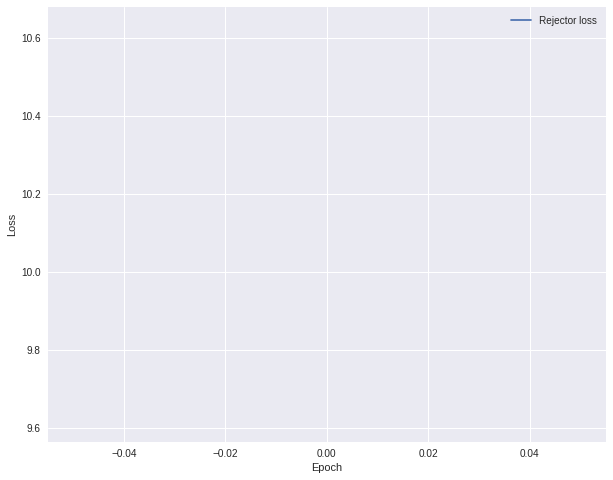

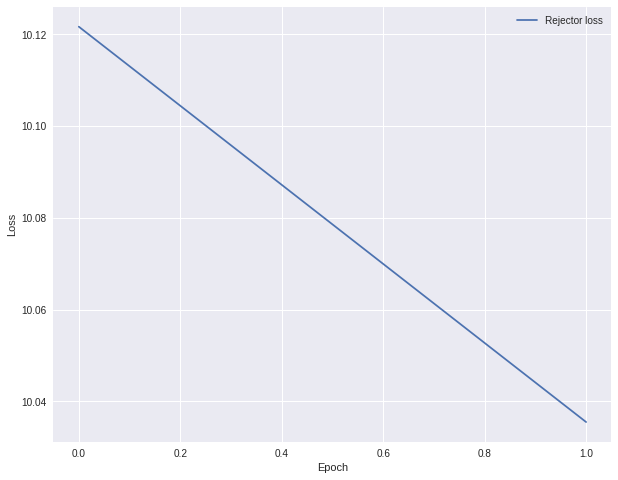

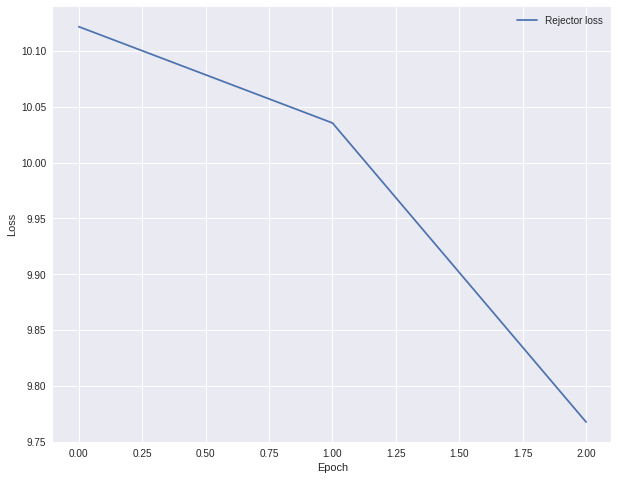

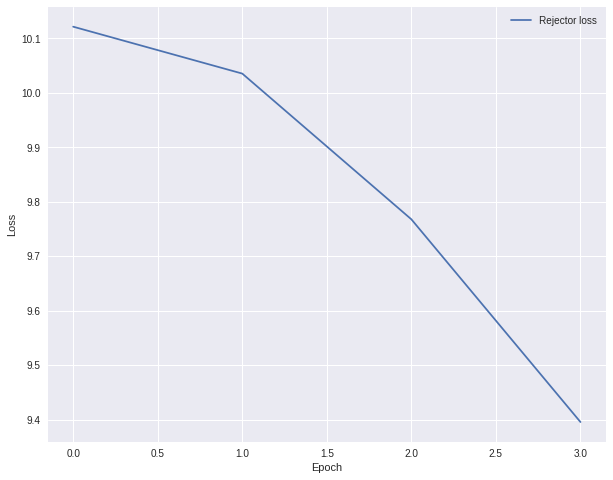

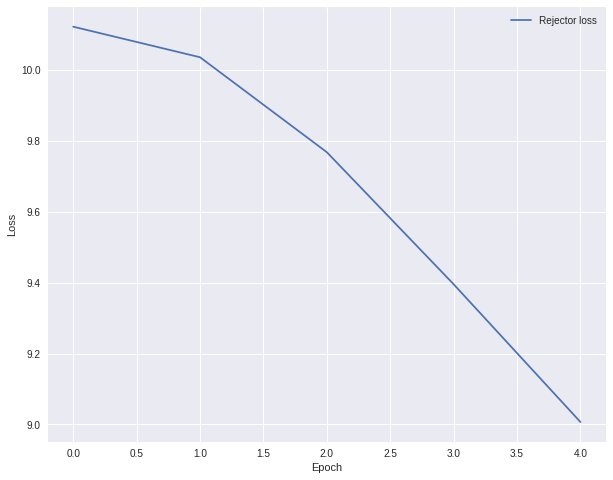

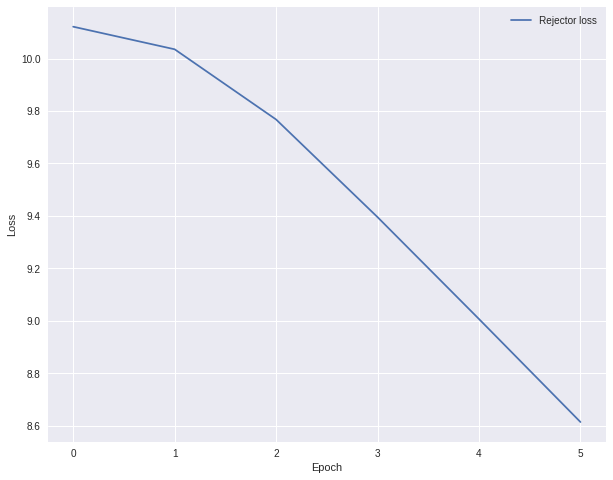

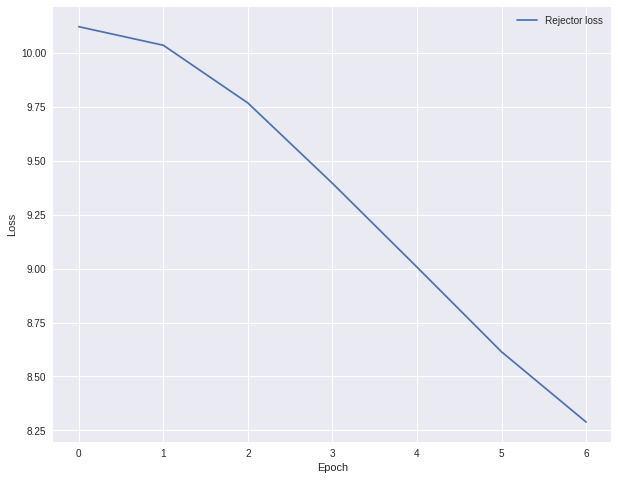

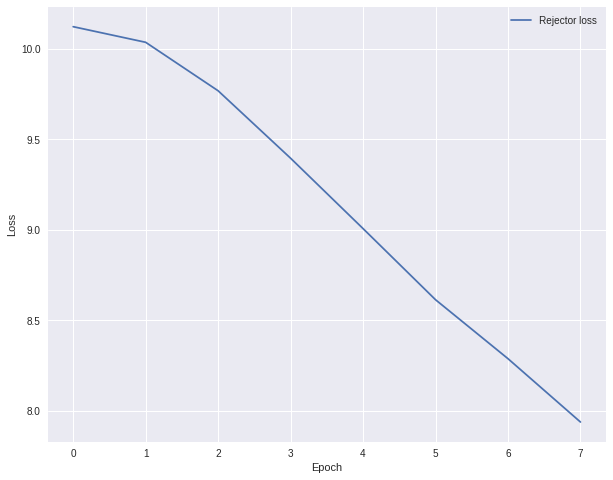

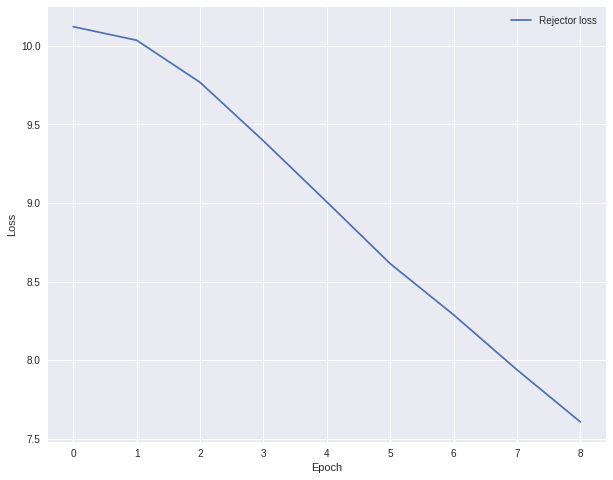

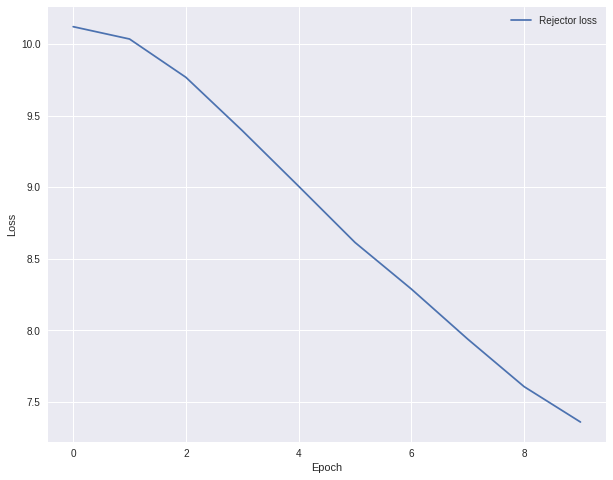

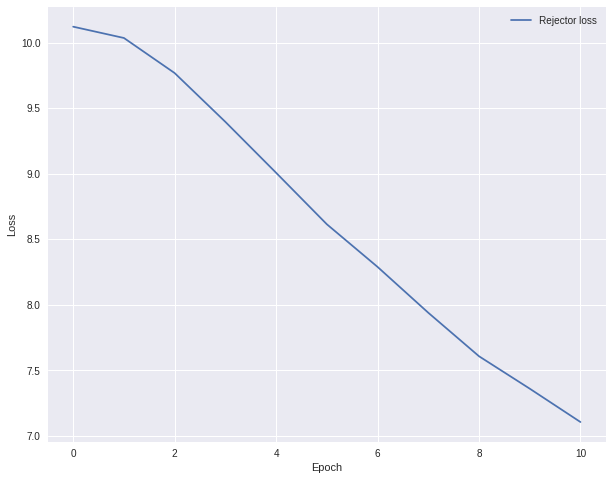

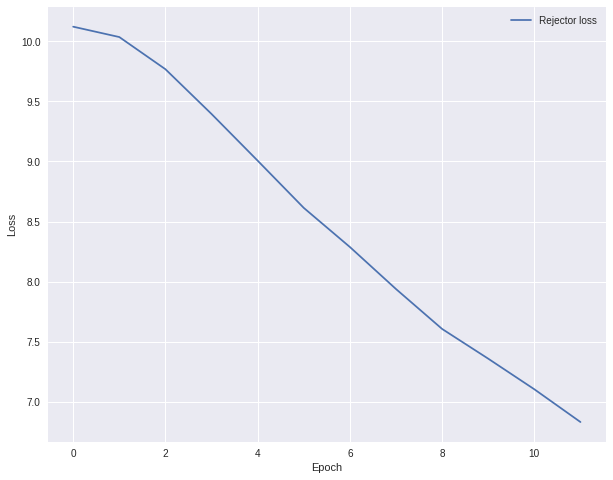

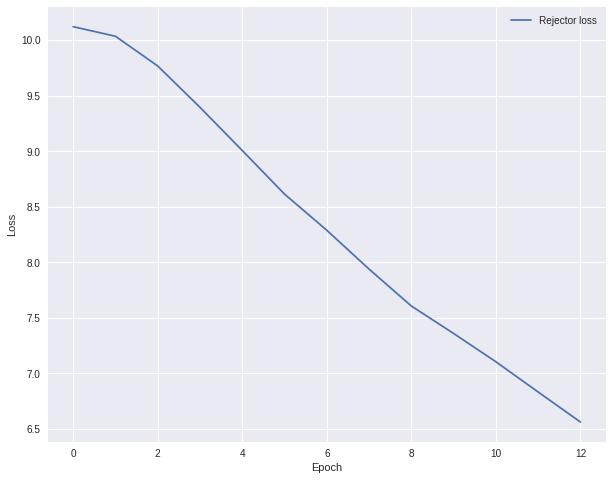

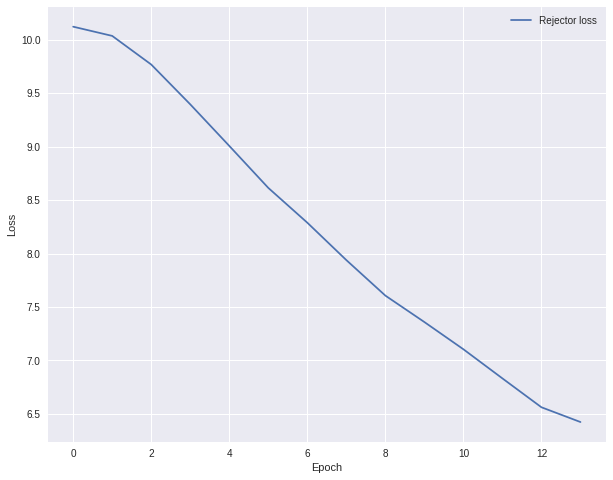

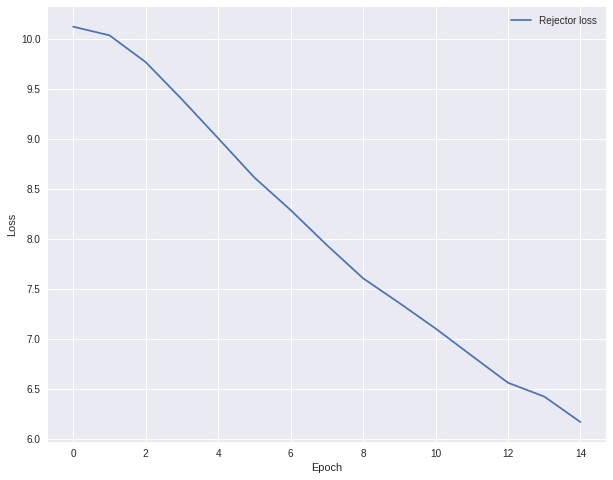

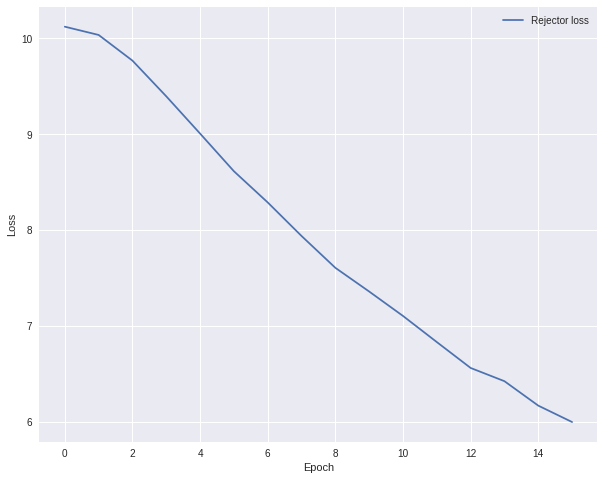

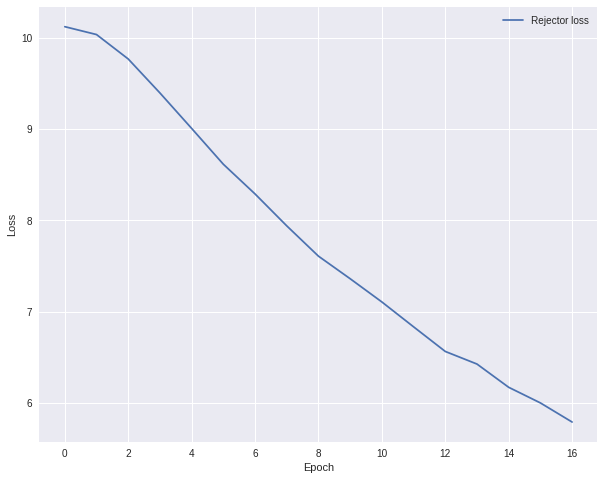

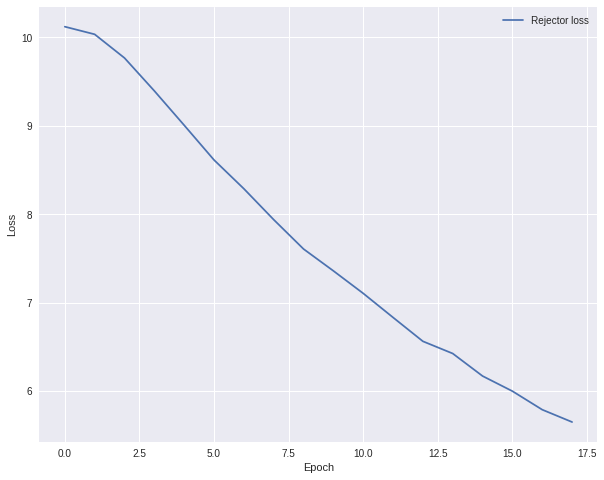

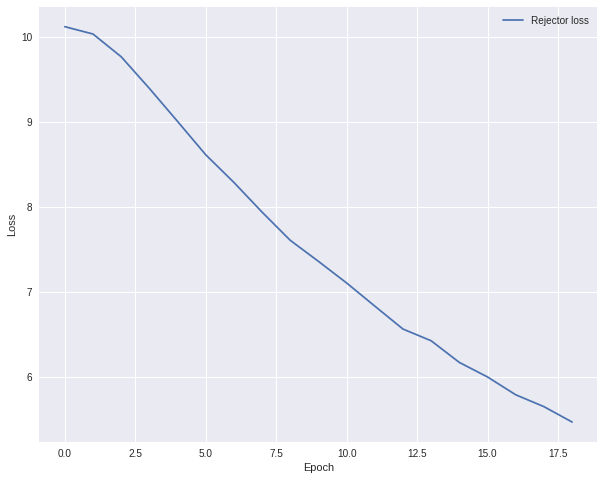

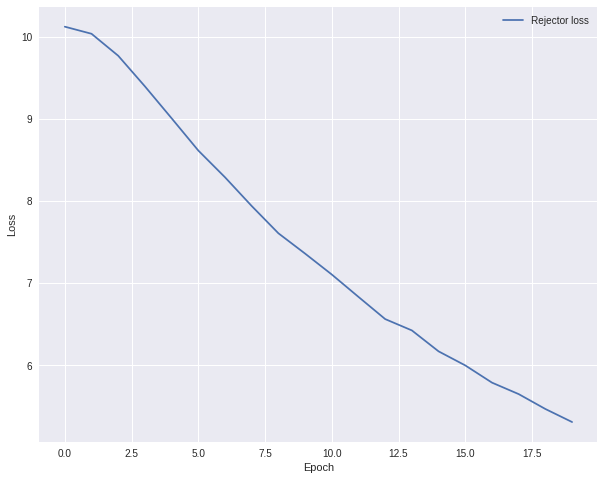

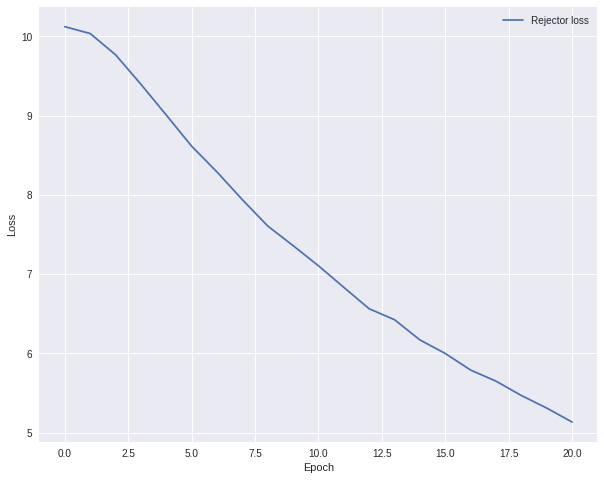

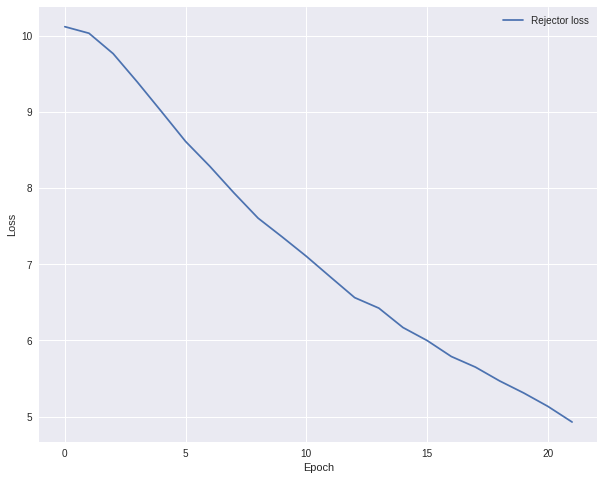

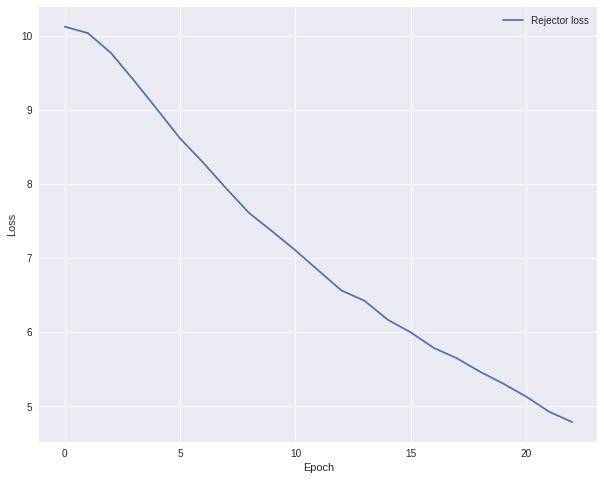

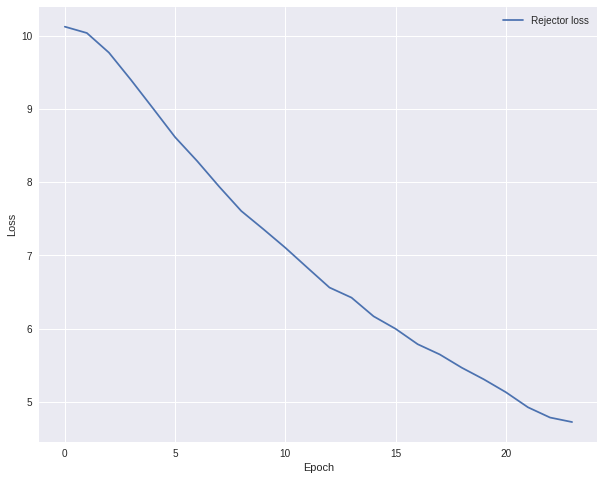

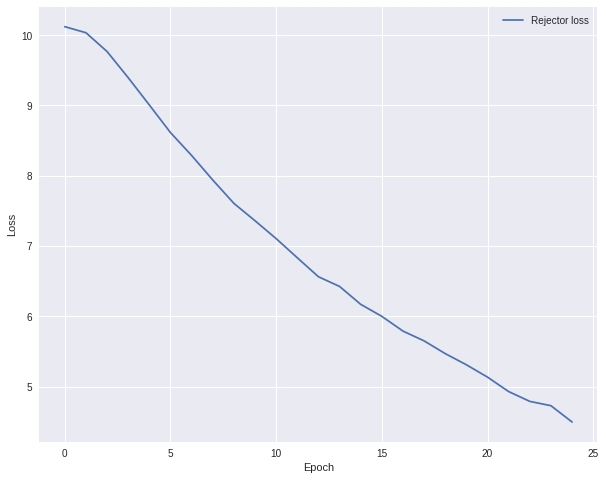

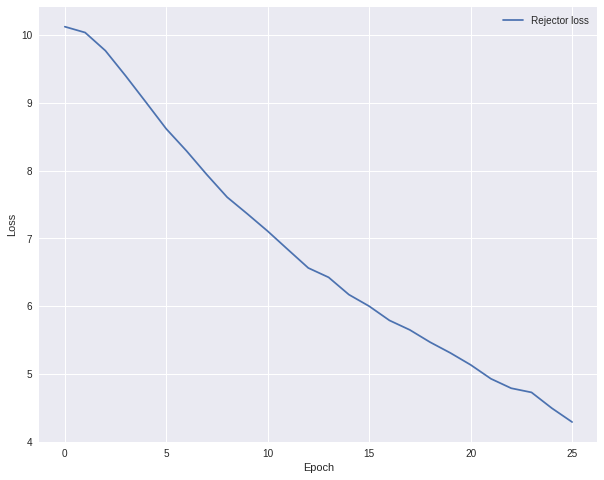

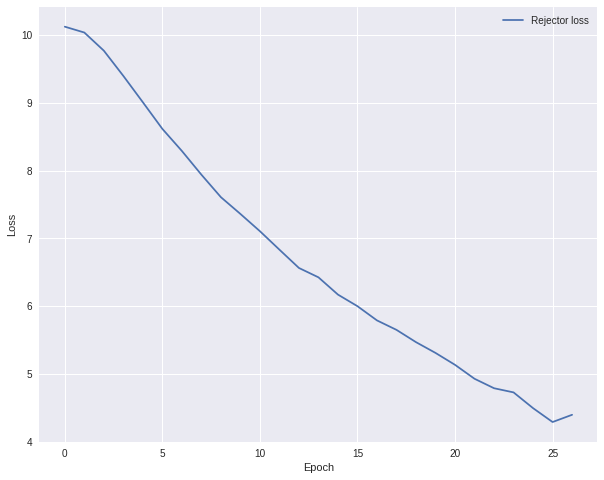

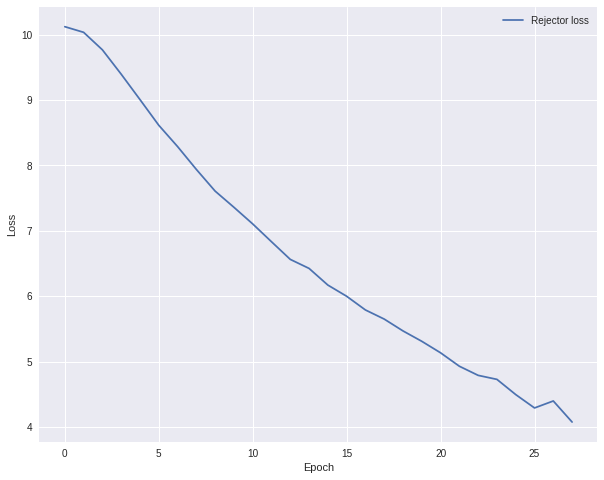

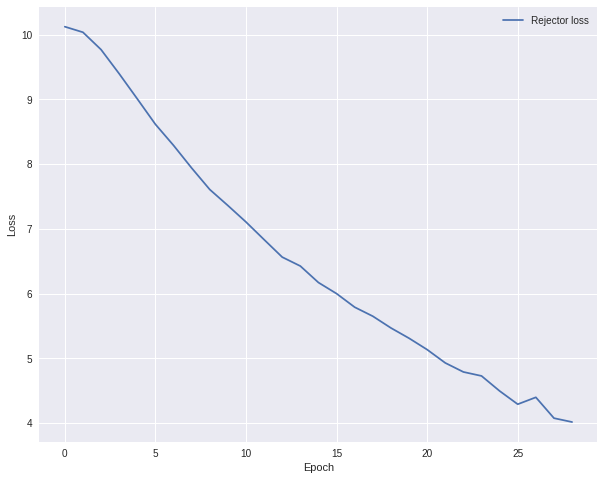

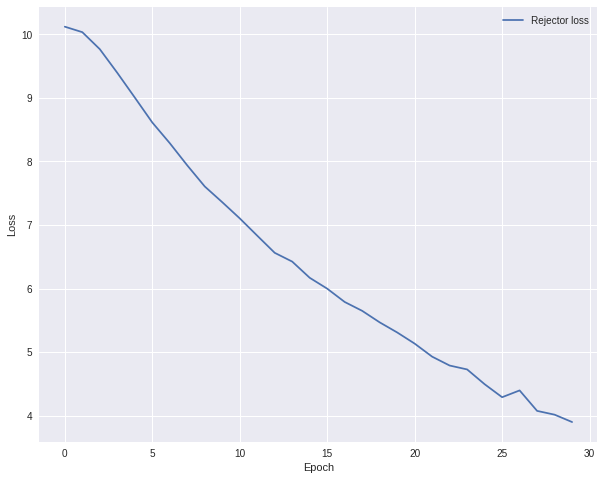

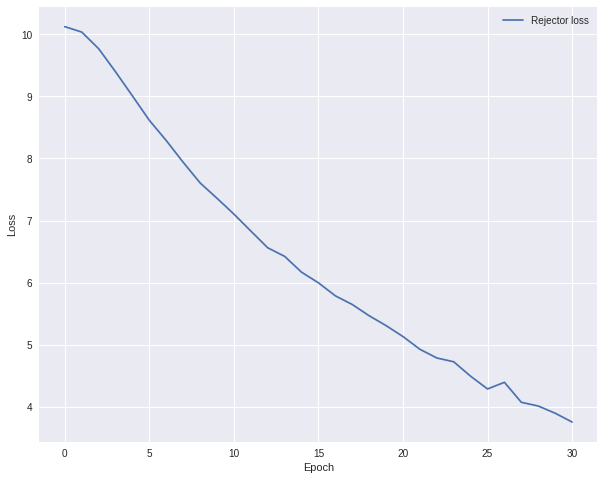

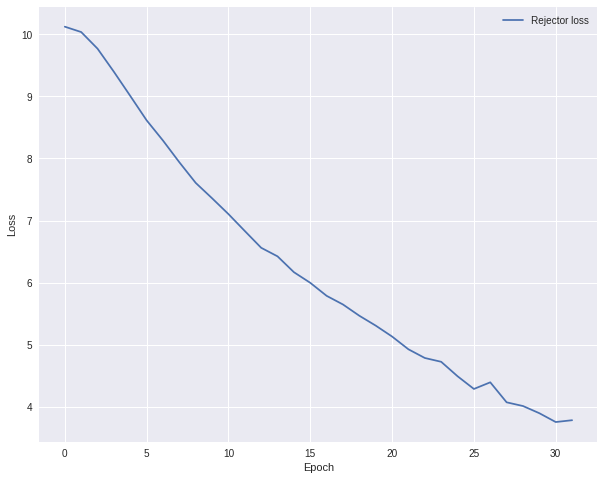

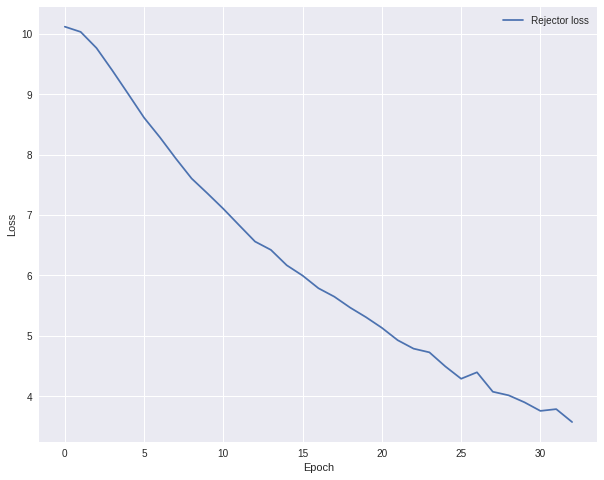

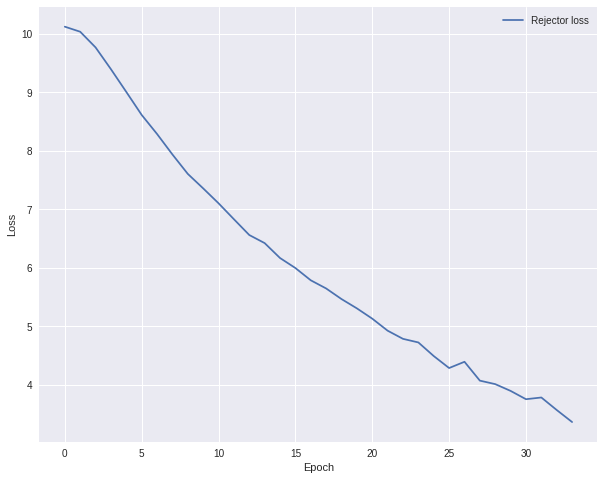

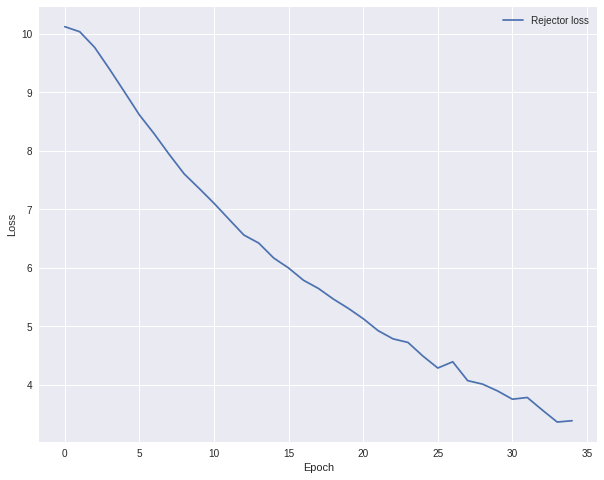

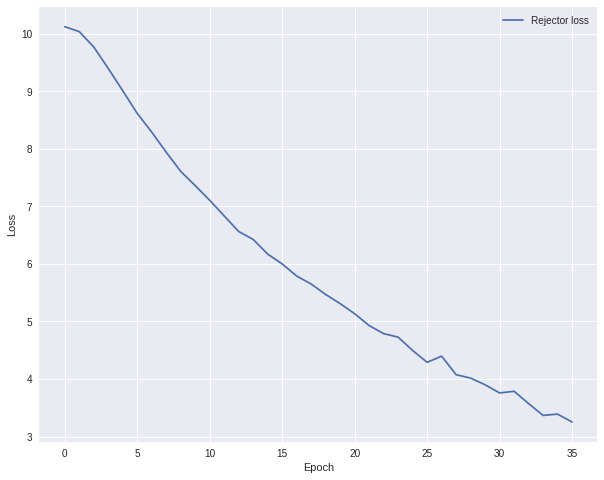

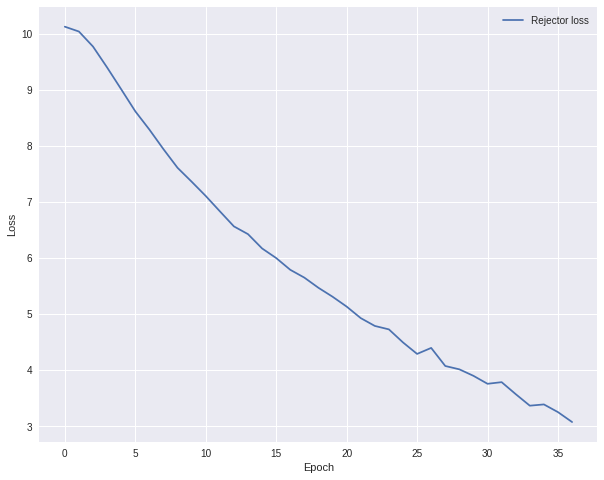

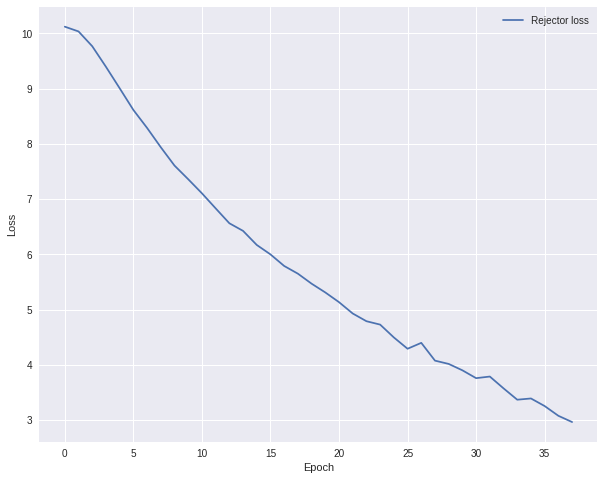

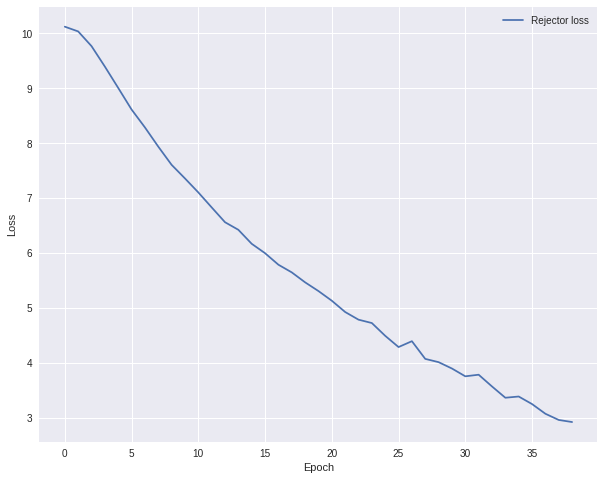

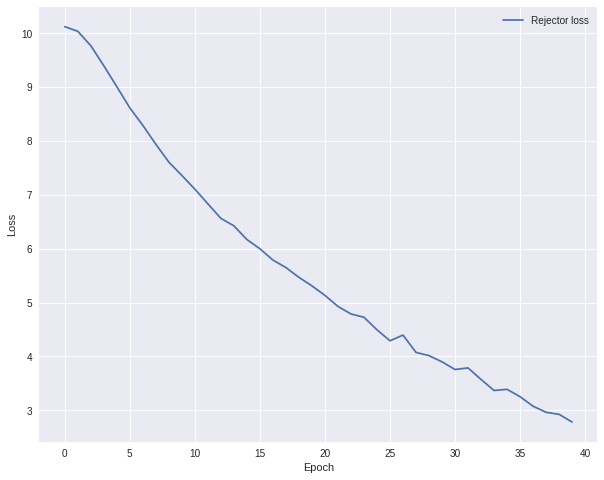

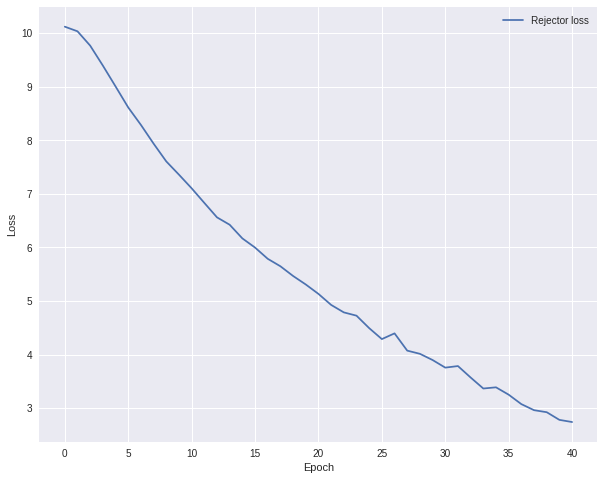

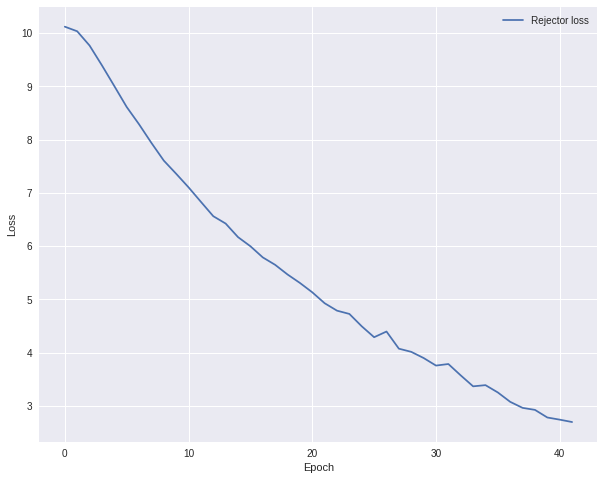

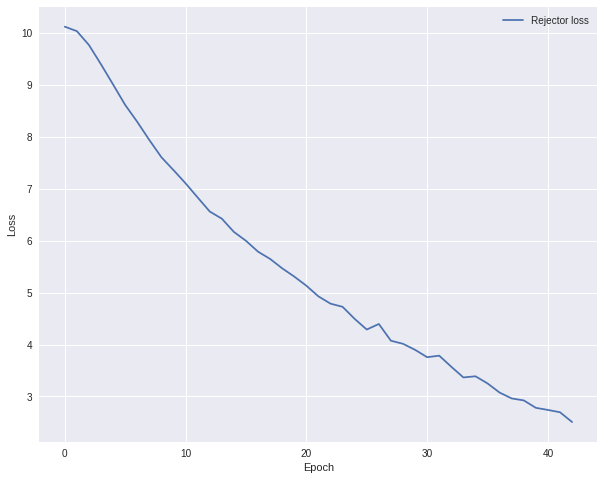

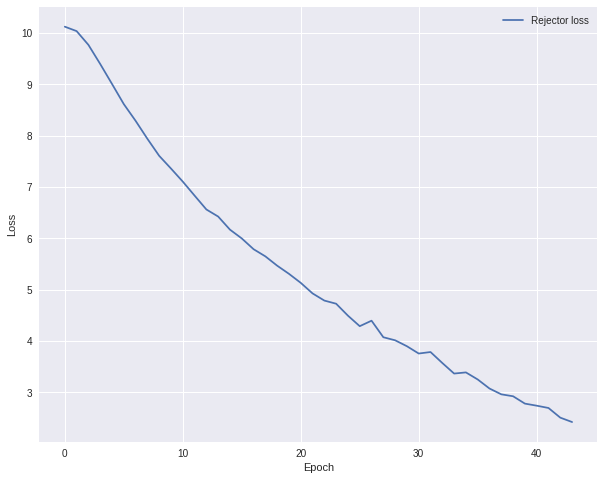

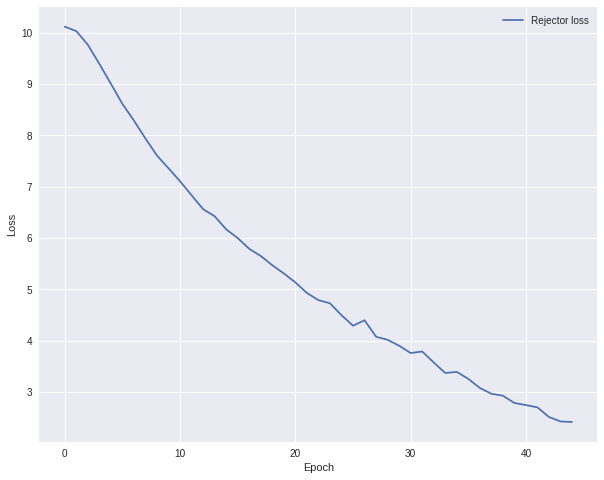

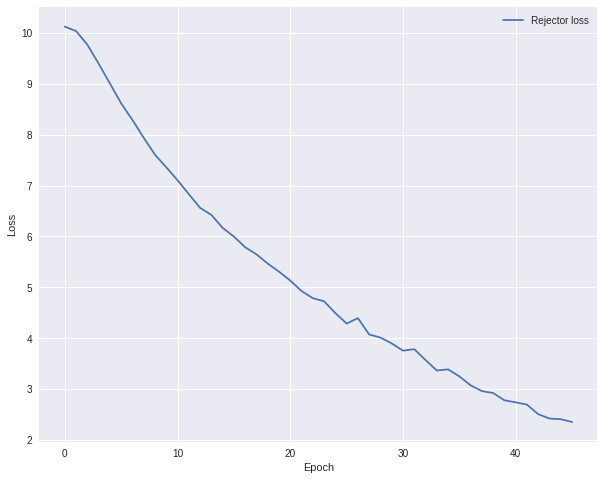

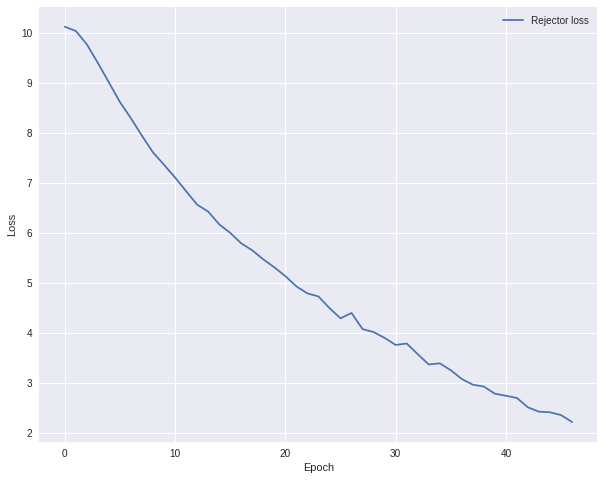

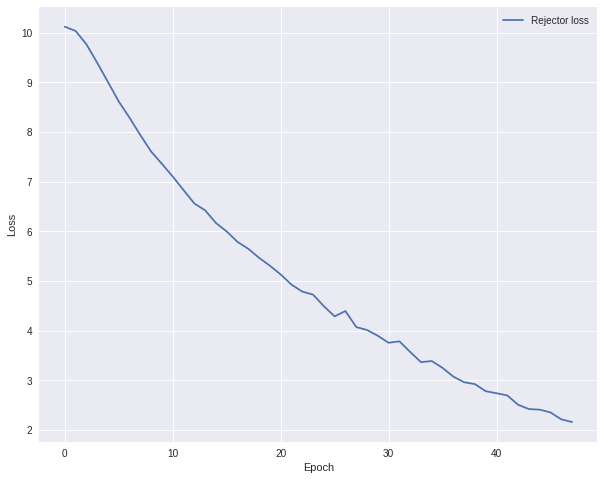

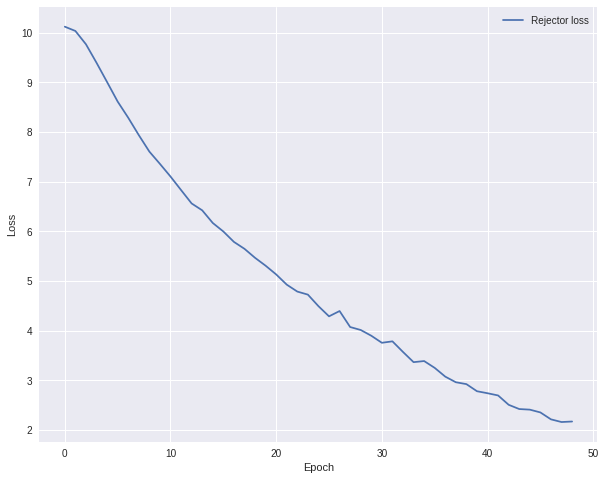

In [90]:
train_rejector_on_bdd(X_train, 4, batchSize=128)

In [91]:
loadRejector(rejector)
scores = rejector.predict(X_test)
classifier = loadClassifier()
repartition = np.linspace(0,1,20)

[0.92427033 0.8892202  0.90992147 0.5202673  0.9008017  0.8874044
 0.9228692  0.89485824 0.7971975  0.85607946 0.8983127  0.8833025
 0.91051745 0.9113715  0.71187663 0.8555857  0.789325   0.89515245
 0.75141835 0.8524963  0.74679947 0.8946422  0.9241805  0.8671884
 0.5903393  0.48790726 0.8195786  0.75050724 0.9200019  0.696139
 0.5847478  0.64068323 0.8772386  0.86343795 0.88146955 0.9229414
 0.7137202  0.78924906 0.9078665  0.8949004  0.73869073 0.88194776
 0.91506475 0.9065325  0.8723142  0.76758236 0.6166495  0.87244576
 0.8006071  0.8482361  0.777673   0.8318909  0.89346755 0.5633689
 0.86870843 0.7860849  0.87407535 0.6989082  0.91247725 0.6993138
 0.81114525 0.66464174 0.7254725  0.8849705  0.89761084 0.80494684
 0.90736663 0.76242167 0.71854293 0.9149152  0.8812471  0.91682035
 0.9125642  0.8960695  0.7850196  0.63822925 0.7371412  0.895834
 0.9081078  0.8724143  0.7485421  0.8422679  0.8154627  0.83360255
 0.8849424  0.8956633  0.9230366  0.91482097 0.91371757 0.5539941
 0.868

10000/10000 [==============================] - 3s 287us/step
0.10526315789473684 (9977, 28, 28, 1) (9977, 10)
9977/9977 [==============================] - 3s 289us/step
0.15789473684210525 (9936, 28, 28, 1) (9936, 10)
9936/9936 [==============================] - 3s 285us/step
0.21052631578947367 (9889, 28, 28, 1) (9889, 10)
9889/9889 [==============================] - 3s 288us/step
0.2631578947368421 (9825, 28, 28, 1) (9825, 10)
9825/9825 [==============================] - 3s 289us/step
0.3157894736842105 (9765, 28, 28, 1) (9765, 10)
8736/9765 [=========================>....] - ETA: 0s

9765/9765 [==============================] - 3s 287us/step
0.3684210526315789 (9704, 28, 28, 1) (9704, 10)
9704/9704 [==============================] - 3s 291us/step
0.42105263157894735 (9614, 28, 28, 1) (9614, 10)
9614/9614 [==============================] - 3s 289us/step
0.47368421052631576 (9511, 28, 28, 1) (9511, 10)
9511/9511 [==============================] - 3s 285us/step
0.5263157894736842 (9371, 28, 28, 1) (9371, 10)
9371/9371 [==============================] - 3s 292us/step
0.5789473684210527 (9196, 28, 28, 1) (9196, 10)
9196/9196 [==============================] - 3s 295us/step
0.631578947368421 (8971, 28, 28, 1) (8971, 10)
 576/8971 [>.............................] - ETA: 2s

8971/8971 [==============================] - 3s 290us/step
0.6842105263157894 (8668, 28, 28, 1) (8668, 10)
8668/8668 [==============================] - 2s 286us/step
0.7368421052631579 (8172, 28, 28, 1) (8172, 10)
8172/8172 [==============================] - 2s 287us/step
0.7894736842105263 (7391, 28, 28, 1) (7391, 10)
7391/7391 [==============================] - 2s 291us/step
0.8421052631578947 (5903, 28, 28, 1) (5903, 10)
5903/5903 [==============================] - 2s 289us/step
0.894736842105263 (2987, 28, 28, 1) (2987, 10)
2987/2987 [==============================] - 1s 298us/step
0.9473684210526315 (0, 28, 28, 1) (0, 10)
1.0 (0, 28, 28, 1) (0, 10)


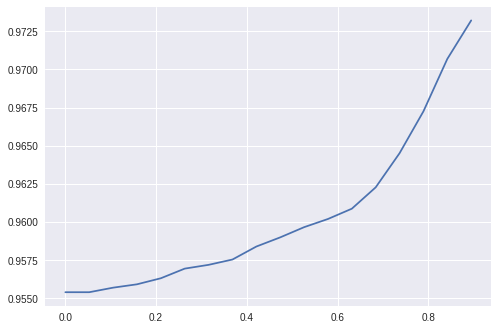

In [92]:
results = []
print(scores[:100,0])
for i in repartition:
  X_2 = X_test[np.where(scores[:,0] > i)]
  Y_2 = Y_test[np.where(scores[:,0] > i)]
  print(i,X_2.shape,Y_2.shape)
  if X_2.shape[0]!=0:
    results.append(classifier.evaluate(X_2,Y_2)[1])
plt.plot(repartition[:len(results)],results)

In [94]:
examples = open_data('bdd_1_3_e35')
print(examples.shape)
scores = rejector.predict(examples)
print(scores)

FileNotFoundError: ignored

In [95]:
!ls

10_classifier	       rejector_loss_e16.png  rejector_loss_e36.png
bdd_1_3_e0	       rejector_loss_e17.png  rejector_loss_e37.png
bdd_1_3_e1	       rejector_loss_e18.png  rejector_loss_e38.png
bdd_1_3_e2	       rejector_loss_e19.png  rejector_loss_e39.png
bdd_1_3_e3	       rejector_loss_e1.png   rejector_loss_e3.png
bdd_1_3_e4	       rejector_loss_e20.png  rejector_loss_e40.png
bdd_1_3_e5	       rejector_loss_e21.png  rejector_loss_e41.png
bdd_1_3_e6	       rejector_loss_e22.png  rejector_loss_e42.png
bdd_1_3_e7	       rejector_loss_e23.png  rejector_loss_e43.png
bdd_1_3_e8	       rejector_loss_e24.png  rejector_loss_e44.png
bdd_1_3_e9	       rejector_loss_e25.png  rejector_loss_e45.png
datalab		       rejector_loss_e26.png  rejector_loss_e46.png
discriminator_e48      rejector_loss_e27.png  rejector_loss_e47.png
generator_e48	       rejector_loss_e28.png  rejector_loss_e48.png
models		       rejector_loss_e29.png  rejector_loss_e49.png
rejector	       rejector_loss_e2.png   rejector_lo

# TESTS

In [0]:
#@title SEUILLAGES

"""Importer le modèle à 95-96%"""

model_95=load_model('10_classifier')

#entropie
seuils=np.concatenate((np.linspace(3.3,3.32,4),np.linspace(3.32,3.323,20)))
x=[]
y=[]
lim=10001
current=0
i=0
while i<len(seuils) and current<lim:
  print(str(i+1)+"/"+str(len(seuils)))
  point=test_model_entropie(model_95,seuils[i],x_test,y_test)
  x.append(point[0])
  y.append(point[1])
  i+=1
  current=point[0]

  
o=np.ones(len(x))
plt.plot(x,y,'b',label="entropie")
plt.plot(x,o,'r')

#max
seuils=np.concatenate((np.linspace(0,0.1,6),np.linspace(0.1,0.11,10),np.linspace(0.11,1,2)))
x=[]
y=[]
lim=10000
current=0
i=0
while i<len(seuils) and current<lim:
  print(str(i+1)+"/"+str(len(seuils)))
  point=test_model(model_95,seuils[i],x_test,y_test)
  x.append(point[0])
  y.append(point[1])
  print(point)
  i+=1
  current=point[0]


plt.plot(x,y,'g',label="max")
plt.xlabel("Nombre d'images rejetées")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# DERNIERS CHANGEMENTS / ETAT DES LIEUX

Ajout du code d'Artieres : TERMINE

Test du code d'Artieres : OK
- Entraînement : OK
- Tests : OK
- Autres fonctions : OK

Codes d'entraînement séparés : EN COURS
- GAN seul : A TESTER
- Création BDD : A FAIRE
- REJECTOR seul : A FAIRE
- CLASSIFIEUR seul : A ECRIRE (importer le modèle déjà prêt)

Nouvelles fonctions de choix des exemples : A VENIR

METHODE 1 : Curriculum learning

Plusieurs possibilités d'apprentissage progressif :

1) Chaque epoch d'apprentissage du REJECTOR est composée d'exemples générés par l'epoch correspondante du generator et filtrés par le DISCRIMINATOR correspondant

2) Même chose mais on filtre avec le DISCRIMINATOR final

3) Chaque epoch d'apprentissage du REJECTOR est composée d'exemples générés par l'epoch correspondante et d'exemples générés précédemment, filtrés par le DISCRIMINATOR correspondant

4) Même chose mais on filtre avec le DISCRIMINATOR final

[5) Pour chaque epoch, le nième batch est constitué d'images générées par la nième epoch du GAN, filtrées par le DISCRIMINATOR correspondant]

[6) Même chose mais on filtre avec le DISCRIMINATOR final]

7) On commence par générer une grande base de données avec toutes les epochs du GAN, que l'on ordonne grâce à leurs score par le DISCRIMINATOR final pour créer les batchs des différentes epochs

Priorité : METHODE 2 : Traditionnal learning

On commence par générer une base de données avec les différentes epochs du GAN, pour lesquelles on a les options suivantes :
 - filtrer par le DISCRIMINATOR correspondant ou le DISCRIMINATOR final
 - attribuer un poids grâce au score du DISCRIMINATOR final ou non
 - inclure des exemples de MNIST découpés ou non, que l'on peut tester avec le DISCRIMINATOR final ou non
 - mélanger la base de données avant de commencer ou non
 - imposer la répartition des exemples entre les différentes epochs du GAN ou laisser générer en fonction du pourcentage d'exemples pertinents à chaque epochs


Pour la base de données positive, on choisit évidemment les classes retenues de MNIST, et on choisit les éléments de chaque batch aléatoirement avec remise.

A AJOUTER :
 - utilisation de plusieurs GANs
 - autres méthodes génératives
 - changer les paramètres ou initialisations des mêmes GANs